# Mount Notebook to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction

The paper our group has chosen is **SANSformers: Self-Supervised Forecasting in
Electronic Health Records with
Attention-Free Models.**

* **Background:**
  * **Problem:**
    * This paper tackles three distinct prediction problems, however, two rely on the confidential Pummel dataset, so we will focus on the third problem: **mortality prediction with MIMIC data.**
  * **Importance of Problem:**
    * Accurate mortality prediction is important for many reasons including improving patient care, correctly allocating resources, and assisting in clinical decision making. Accurate mortality prediction helps to tailor treatment plans and focus resources on patients with higher mortality likelihood. Additionally, it can help medical staff to make life-saving decisions around intensity of care.
  * **Difficulty of Problem:**
    * One difficulty of mortality prediction relates to the data it relies upon, EHR data. EHR data is a natural language input from healthcare professionals, so the data accuracy relies on accurate input by busy healthcare professionals. Additionally, the unique structure and charateristics of EHR data, especially the sequences of clinical codes, present challenges for Transformers because the consecutive visits in an EHR dataset are not always strongly correlated.
  * **State of the Art Methods and Effectiveness:** This paper compared results against 5 state of the art models. These models mainly relied on Transformers with attention mechanisms. Additionally, because of the complexity of prediction on EHR data, Lasso regression with complex feature engineering of EHR data has proven a comparable baseline.
    * L1-reg Logistic Regression: Traditional Lasso regression method with feature engineering which proves comparable to complex Transformer methods on EHR data.
      * Narges Razavian, Saul Blecker, Ann Marie Schmidt, Aaron Smith- McLallen, Somesh Nigam, and David Sontag. Population-level pre- diction of type 2 diabetes from claims data and analysis of risk factors. Big Data, 3(4):277–287, 2015.
    * RETAIN: A Transformer approach using a "reverse time attention mechanism"
      * Edward Choi, Mohammad Taha Bahadori, Joshua A Kulas, Andy Schuetz, Walter F Stewart, and Jimeng Sun. RETAIN: An interpretable predictive model for healthcare using reverse time attention mechanism. Advances in Neural Information Processing Systems, pages 3512–3520, 2016.
    * BEHRT: Transformer architecture trained on
      * Yikuan Li, Shishir Rao, Jose ́ Roberto Ayala Solares, Abdelaali Hassaine, Rema Ramakrishnan, Dexter Canoy, Yajie Zhu, Kazem Rahimi, and Gholamreza Salimi-Khorshidi. BEHRT: Transformer for electronic health records. Scientific Reports, 10(1):1–12, 2020.
    * BRLTM: Bidirectional representation learning from transformers using multi- modal electronic health record data.
      * Yiwen Meng, William Speier, Michael K Ong, and Corey W Arnold. Bidirectional representation learning from transformers using multi- modal electronic health record data to predict depression. IEEE Journal of Biomedical and Health Informatics, 25(8):3121–3129, 2021.
    * SARD: "Self Attention with Reverse Distillation employs a mix of contextual and temporal embedding along with self-attention mechanisms" (page 3)
      * Rohan Kodialam, Rebecca Boiarsky, Justin Lim, Aditya Sai, Neil Dixit, and David Sontag. Deep contextual clinical prediction with reverse distillation. In Proceedings of the AAAI Conference on Artificial Intelligence, volume 35, pages 249–258, 2021.

* **Paper Explanation:**
  * **What did the paper propose?** This paper proposed a new architecture for healthcare prediction tasks with EHR data, the SANSformer architecture.
  * **Innovations of the Method** The main innovations of this paper are the following:
    * Removing Self-Attention Mechanism: this paper proposes sequential architecture for EHR analysis, eliminating the self-attention mechanism, which they hypothesize is too complex for EHR data.
    * Generative Summary Pre-training: This paper borrows the pre-training strategy commonly used in NLP and computer vision tasks. This paper calls their approach Generative Summary Pre-training (GSP), where they predict summary statistics for a future window allowing for more reliable pretraining.
    * Axial Decomposition: The SANSformers model leverages axial decomposition to better model interactions within intra-visit data.
  * **How well does the method work?** On the MIMIC mortality task, both the Additive and Axial SANSformer models performed better than comparable methods on AUC over 5 runs. The means AUC scores for each of the 5 runs are reported below:
    * L1-reg Logistic Regression: 0.728
    * RETAIN: 0.707
    * BEHRT: 0.693
    * BRLTM: 0.695
    * SARD: 0.742
    * Additive SANSformer: 0.759
    * Axial SANSformer: 0.761
  * **What is the contribution of the research regime?** According to page 2 of the paper, the research regime claims the following contributions:
    * They introduce SANSformers, a novel, attention-free sequential model specifically designed for EHR data, supplemented with inductive biases such as axial decomposition and ∆τ embeddings to cater to the unique challenges posed by the EHR domain.
    * We conduct extensive comparisons of SANSformers with strong baseline models on two real-world EHR datasets. Our results highlight the superior data efficiency and prediction accuracy of our model compared to the existing baselines.
    * We demonstrate the value of self-supervised pre-training on a larger population for predicting future healthcare utilization of smaller, distinct patient subgroups. We introduce Generative Summary Pre-training (GSP), a self- supervised pre-training objective for EHR data, predict- ing future summary statistics. This offers considerable potential in improving healthcare resource allocation predictions, an application of significant importance in healthcare management.
    

# Scope of Reproducibility:

**Hypothesis:** Upon reproduction, the SANSformer model will outperform baselines in the MIMIC mortality prediction task, as claimed in the paper.



![SANSformer Architecture](https://drive.google.com/uc?export=view&id=1kz4TGgcy2DNAeLn6r-LFDj7BgDfUsYj8)

# Methodology


In [ ]:
# import  packages you need
import re
from pathlib import Path
from google.colab import drive

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm.auto import tqdm

TARGET_OFFSET = 2
MIMIC_PATH = './drive/MyDrive/mimic-iv-1.0/'
OUTPUT_PATH = MIMIC_PATH + 'output/'

##  Data
**Source of the Data:**
  * The data utilized comes from the [MIMIC-IV v1.0](https://physionet.org/content/mimiciv/1.0/) dataset which contains electronic health records of around 250,000 patients. It features extensive patient data including vitals, doctor notes, diagnoses, procedures, and more. Our paper focuses soley on hospital admissions, extracting relevant information from patients, admissions, diagnoses ICD, procedures ICD, drgcodes, and service tables.

In [ ]:
# dir and function to load raw data
def load_raw_data(filename, raw_data_dir=MIMIC_PATH, compression='gzip', **kwargs):
  # implement this function to load raw data to dataframe/numpy array/tensor
  try:
      filepath = raw_data_dir + filename
      # Load the compressed CSV file
      data = pd.read_csv(filepath, compression=compression, **kwargs)
      print(f"{filename} file loaded successfully.")
      return data
  except Exception as e:
        print(f"An error occurred: {e}")

# calculate statistics
def calculate_stats(raw_data):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results
  return raw_data.describe()

In [ ]:
admits = load_raw_data(
    "core/admissions.csv.gz",
    parse_dates=["admittime", "dischtime"],
)
patients = load_raw_data('core/patients.csv.gz')
diags = load_raw_data("hosp/diagnoses_icd.csv.gz")
procs = load_raw_data("hosp/procedures_icd.csv.gz")
drgs = load_raw_data("hosp/drgcodes.csv.gz")
services = load_raw_data("hosp/services.csv.gz")

core/admissions.csv.gz file loaded successfully.
core/patients.csv.gz file loaded successfully.
hosp/diagnoses_icd.csv.gz file loaded successfully.
hosp/procedures_icd.csv.gz file loaded successfully.
hosp/drgcodes.csv.gz file loaded successfully.
hosp/services.csv.gz file loaded successfully.


**Statistics**
  * This is the dataset prior to being preprocessed.
![Mimic Dataset](https://drive.google.com/uc?export=view&id=13z5ma7Rn-Dm_wYVAowHfRP0z3J-HN2Kf)

In [ ]:
print("Patient Statistics")
print(calculate_stats(patients), "\n")
print("Diagnoses ICD Statistics")
print(calculate_stats(diags), "\n")
print("Procedures ICD Statistics")
print(calculate_stats(procs), "\n")
print("DRG Codes Statistics")
print(calculate_stats(drgs), "\n")
print("Services Statistics")
print(calculate_stats(services))

Patient Statistics
         subject_id     anchor_age    anchor_year
count  3.822780e+05  382278.000000  382278.000000
mean   1.500927e+07      40.931804    2150.844430
std    2.885080e+06      26.114457      23.389475
min    1.000002e+07       0.000000    2109.000000
25%    1.251226e+07      22.000000    2131.000000
50%    1.501350e+07      41.000000    2151.000000
75%    1.750570e+07      62.000000    2171.000000
max    1.999999e+07      91.000000    2208.000000 

Diagnoses ICD Statistics
         subject_id       hadm_id       seq_num   icd_version
count  5.280351e+06  5.280351e+06  5.280351e+06  5.280351e+06
mean   1.499741e+07  2.500180e+07  8.174094e+00  9.414742e+00
std    2.878713e+06  2.888808e+06  6.515281e+00  4.926774e-01
min    1.000002e+07  2.000002e+07  1.000000e+00  9.000000e+00
25%    1.249952e+07  2.250008e+07  3.000000e+00  9.000000e+00
50%    1.499722e+07  2.500333e+07  6.000000e+00  9.000000e+00
75%    1.749305e+07  2.750520e+07  1.100000e+01  1.000000e+01
max    1

**Data Processing Overview:**

The provided code encompasses a comprehensive data processing pipeline tailored for medical data. It includes several steps such as sampling data, merging datasets, handling missing values, preprocessing textual data (ICD codes, procedures, etc.), and encoding categorical features. Below are the key steps involved:

1. **Sampling Data:**
   - Randomly sample data from different sources (admissions, patients, diagnoses, procedures, DRGs, services) based on a specified percentage.

2. **Merging Datasets:**
   - Merge patient information with admission details.
   - Calculate length of stay (LOS) for each patient and cap it at 180 days.
   - Sort patient records based on admission and discharge time.
   - Compute days since the previous admission and bin them into categories.

3. **Processing Diagnosis, Procedure, DRG, and Service Codes:**
   - Preprocess diagnosis, procedure, DRG, and service codes by extracting relevant information and grouping them by admission ID.
   - Encode categorical features such as gender, language, and ethnicity.

4. **Vectorization:**
   - Vectorize textual data (ICD codes, procedures, DRGs, services, admission type, insurance, marital status) using a custom vectorizer.
   - Encode categorical features and save the vectorizer for future use.

5. **Data Splitting:**
   - Split the processed data into training and testing sets using a specified ratio.

6. **Saving Preprocessed Data:**
   - Save the preprocessed data into Feather format files for later use.

**Vocabulary and Sequence Vocabulary**
  * These two classes provide functionality for token-to-index and index-to-token mappings, with the latter extending the former to include special tokens for sequence processing.

In [ ]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError(f"the index ({index}) is not in the Vocabulary")
        return self.idx_to_token[index]

    def __str__(self):
        return f"<{type(self).__name__}(size={len(self)})>"

    def __len__(self):
        return len(self.token_to_idx)

    def to_serializable(self):
        return {"token_to_idx": self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)


class SequenceVocabulary(Vocabulary):
    "Wraps around Vocab to add start and end tokens"

    def __init__(
        self,
        token_to_idx: dict = None,
        unk_token: str = "<unk>",
        begin_seq_token: str = "<sos>",
        end_seq_token: str = "<eos>",
        pad_token: str = "<pad>",
    ):
        super().__init__(token_to_idx)

        self.unk_token = unk_token
        self.pad_token = pad_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token
        self.mask_token = "<mask>"

        self.pad_index = self.add_token(self.pad_token)  # pad token has index 0
        self.mask_index = self.add_token(self.mask_token)  # mask token has index 1
        self.unk_index = self.add_token(self.unk_token)  # unk has index 2
        self.begin_seq_index = self.add_token(self.begin_seq_token)  # begin has index 3
        self.end_seq_index = self.add_token(self.end_seq_token)  # end has index 4

        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index ({index}) is not in the SequenceVocabulary")
        return self.idx_to_token[index]

**EHRCountVectorizer**
  * This class provides functionality to convert sequences of ICD10 codes into vectorized arrays, facilitating the transformation of patient history sequences into indexed representations based on a specified vocabulary.

In [ ]:
class EHRCountVectorizer:
    """
    Vectorizer to convert a sequence of ICD10 code to vectorized arrays
    In this specific instance, output is not a sequence.
    """

    def __init__(self, seq_vocab: SequenceVocabulary):
        self.seq_vocab = seq_vocab
        self.seq_vocab_len = len(self.seq_vocab)

    def vectorize(self, patient_history_seq: str, sep=";"):
        """
        Convert the patient history sequence (diagnoses, procedures, etc) to a list of indeces based on the
        vocabulary object.
        This method also handles the padding of the "inner-list", i.e.,
        the number of diagnoses per visit. Padding the number of visits sequence
        is handled by the collate function in trainer.
        Args:
          diagnoses: String of diagnoses for a patient, each visit
                     separated by ';', diagnoses per
                     visit separated by space
        Returns:
          vectorized_history: list of vectorized visit codes
          n_tkns_per_visit: list of number of tokens per visit
        """
        # split
        visits = [visit for visit in patient_history_seq.split(sep)]
        n_tkns_per_visit = [
            len(visit.split(" ")) for visit in patient_history_seq.split(sep)
        ]

        vectorized_history = []
        max_visit_items = 0
        for visit in visits:
            items_per_visit_i = [
                self.seq_vocab.lookup_token(token) for token in visit.split(" ")
            ]
            items_per_visit_i_length = len(items_per_visit_i)

            if max_visit_items < items_per_visit_i_length:
                max_visit_items = items_per_visit_i_length
            vectorized_history.append(items_per_visit_i)

        return vectorized_history, n_tkns_per_visit

    @classmethod
    def from_dataframe_cols(cls, df, col_names):
        seq_vocab = SequenceVocabulary()
        for colname in col_names:
            df[colname] = df[colname].apply(
                lambda row: row.replace(";", " ").split(" ")
            )
            seq_vocab.add_tokens(np.concatenate(df[colname].values))
        print(f"Corpus has {len(seq_vocab)} unique tokens")
        return cls(seq_vocab)

    @classmethod
    def from_dataframe(cls, df, colname="icd10"):
        seq_vocab = SequenceVocabulary()
        df[colname] = df[colname].apply(lambda row: row.replace(";", " ").split(" "))
        seq_vocab.add_tokens(np.concatenate(df[colname].values))

        print(f"Corpus has {len(seq_vocab)} unique tokens")
        return cls(seq_vocab)

**Data Processing**

In [ ]:
# process raw data
def process_data(admits, patients, diags, procs, drgs, services, sample_percentage=0.3):

  admits_sample_size = int(len(admits) * sample_percentage)
  patients_sample_size = int(len(patients) * sample_percentage)
  diags_sample_size = int(len(diags) * sample_percentage)
  procs_sample_size = int(len(procs) * sample_percentage)
  drgs_sample_size = int(len(drgs) * sample_percentage)
  services_sample_size = int(len(services) * sample_percentage)

  admits = admits.sample(n=admits_sample_size, random_state=42)
  patients = patients.sample(n=patients_sample_size, random_state=42)
  diags = diags.sample(n=diags_sample_size, random_state=42)
  procs = procs.sample(n=procs_sample_size, random_state=42)
  drgs = drgs.sample(n=drgs_sample_size, random_state=42)
  services = services.sample(n=services_sample_size, random_state=42)

  # implement this function to process the data as you need
  patients = patients.merge(admits, on="subject_id", how="right")
  patients["los"] = patients["dischtime"] - patients["admittime"]
  patients["los"] = patients["los"].dt.total_seconds() / 86400.0
  # topcap los at 180 days
  patients["los"] = np.clip(patients["los"], 0, 180)
  patients.drop(
      [
          "discharge_location",
          "anchor_year_group",
          "anchor_year",
          "admission_location",
          "discharge_location",
          "edregtime",
          "edouttime",
      ],
      axis=1,
      inplace=True,
  )
  patients.sort_values(["subject_id", "admittime", "dischtime"], inplace=True)
  patients["days_from_prev"] = patients["admittime"] - patients["admittime"].shift(1)
  patients["days_from_prev"] = patients["days_from_prev"].dt.total_seconds() / 86400.0
  bin_edges = np.arange(0, np.max(patients["days_from_prev"]) + 16, 15)
  patients["days_from_prev"] = np.digitize(patients["days_from_prev"].values, bin_edges)

  # store the last recorded hospital_expire_flag as the flag for the patient
  patients = patients.drop("hospital_expire_flag", axis=1).join(
      patients.groupby("subject_id")[["subject_id", "hospital_expire_flag"]]
      .tail(1)
      .set_index("subject_id"),
      on="subject_id",
      how="inner",
  )

  # drop last visits for each patient
  hadm_to_drop = (
      patients.groupby("subject_id")[["dischtime", "hadm_id"]].tail(TARGET_OFFSET).hadm_id
  )
  patients = patients[~patients["hadm_id"].isin(hadm_to_drop)]

  # processing diagnosis codes
  # diags = diags.reset_index()
  diags["icd_code"] = diags["icd_code"].apply(lambda row: row[:3])
  diags["icd_version"] = diags["icd_version"].apply(lambda row: f"IP{row}_")
  diags["icd_all"] = diags["icd_version"] + diags["icd_code"]
  print(diags.head())

  # group diag codes according to admission id
  n_unique_admid = diags.hadm_id.nunique()
  diags.set_index("hadm_id", inplace=True)
  diag_cols = ["subject_id", "hadm_id", "icd_all"]
  grouped_dict = {k: [] for k in diag_cols}

  for g, f in tqdm(diags.groupby(diags.index), total=n_unique_admid):
      grouped_dict["hadm_id"].append(g)
      grouped_dict["subject_id"].append(f.subject_id.values[0])
      for col in diag_cols:
          if col not in ["hadm_id", "subject_id"]:
              grouped_dict[col].append(" ".join(f[col].values))

  grouped_diag = pd.DataFrame(grouped_dict)
  print(grouped_diag.head())
  grouped_diag.to_feather(OUTPUT_PATH + "grouped_diag.feather")

  # processing procedure codes
  # procs = procs.reset_index()
  procs["icd_code"] = procs["icd_code"].apply(lambda row: row[:3])
  procs["icd_version"] = procs["icd_version"].apply(lambda row: f"IP{row}_")
  procs["icd_all"] = procs["icd_version"] + procs["icd_code"]
  print(procs.head())

  # group proc codes according to admit id
  n_unique_admid = procs.hadm_id.nunique()
  procs.set_index("hadm_id", inplace=True)
  diag_cols = ["subject_id", "hadm_id", "icd_all"]
  grouped_dict = {k: [] for k in diag_cols}

  for g, f in tqdm(procs.groupby(procs.index), total=n_unique_admid):
      grouped_dict["hadm_id"].append(g)
      grouped_dict["subject_id"].append(f.subject_id.values[0])
      for col in diag_cols:
          if col not in ["hadm_id", "subject_id"]:
              grouped_dict[col].append(" ".join(f[col].values))

  grouped_proc = pd.DataFrame(grouped_dict)
  grouped_proc.columns = ["subject_id", "hadm_id", "proc_all"]
  print(grouped_proc.head())
  grouped_proc.to_feather(OUTPUT_PATH + "grouped_proc.feather")

  # process drg codes
  drgs.drop(
      ["drg_type", "description", "drg_severity", "drg_mortality"], axis=1, inplace=True
  )
  drgs["drg_code"] = drgs["drg_code"].astype(str)
  print(drgs.head())

  n_unique_admid = drgs.hadm_id.nunique()
  drgs.set_index("hadm_id", inplace=True)
  diag_cols = ["subject_id", "hadm_id", "drg_code"]
  grouped_dict = {k: [] for k in diag_cols}

  for g, f in tqdm(drgs.groupby(drgs.index), total=n_unique_admid):
      grouped_dict["hadm_id"].append(g)
      grouped_dict["subject_id"].append(f.subject_id.values[0])
      for col in diag_cols:
          if col not in ["hadm_id", "subject_id"]:
              grouped_dict[col].append(" ".join(f[col].values))

  grouped_drg = pd.DataFrame(grouped_dict)
  grouped_drg.columns = ["subject_id", "hadm_id", "drug_all"]
  print(grouped_drg.head())
  grouped_drg.to_feather(OUTPUT_PATH + "grouped_drg.feather")

  # process services
  services.drop(["transfertime", "prev_service"], axis=1, inplace=True)
  print(services.head())

  n_unique_admid = services.hadm_id.nunique()
  services.set_index("hadm_id", inplace=True)
  diag_cols = ["subject_id", "hadm_id", "curr_service"]
  grouped_dict = {k: [] for k in diag_cols}

  for g, f in tqdm(services.groupby(services.index), total=n_unique_admid):
      grouped_dict["hadm_id"].append(g)
      grouped_dict["subject_id"].append(f.subject_id.values[0])
      for col in diag_cols:
          if col not in ["hadm_id", "subject_id"]:
              grouped_dict[col].append(" ".join(f[col].values))

  grouped_service = pd.DataFrame(grouped_dict)
  grouped_service.columns = ["subject_id", "hadm_id", "service_all"]
  print(grouped_service.head())
  grouped_service.to_feather(OUTPUT_PATH + "grouped_service.feather")

  # merging everything together
  patients = patients.merge(grouped_diag, on=["subject_id", "hadm_id"], how="left")
  patients = patients.merge(grouped_proc, on=["subject_id", "hadm_id"], how="left")
  patients = patients.merge(grouped_drg, on=["subject_id", "hadm_id"], how="left")
  patients = patients.merge(grouped_service, on=["subject_id", "hadm_id"], how="left")

  # handle missing rows
  for col in patients.columns:
      patients[col].fillna("missing", inplace=True)

  patients.reset_index(inplace=True)
  n_unique_patid = patients.subject_id.nunique()
  patients.set_index("subject_id", inplace=True)
  pat_cols = patients.columns.tolist() + ["subject_id"]
  for col in patients.columns:
      patients[col] = patients[col].astype(str)
  grouped_dict = {k: [] for k in pat_cols}

  for g, f in tqdm(patients.groupby(patients.index), total=n_unique_patid):
      grouped_dict["subject_id"].append(g)
      for col in pat_cols:
          if col not in ["subject_id"]:
              grouped_dict[col].append(";".join(f[col].values))

  grouped_patient = pd.DataFrame(grouped_dict)
  grouped_patient["days_from_prev"] = grouped_patient["days_from_prev"].apply(
      lambda row: ";".join(["0.0"] + row.split(";")[1:])
  )
  num_cols = [
      "gender",
      "anchor_age",
      "dod",
      "deathtime",
      "language",
      "ethnicity",
      "hospital_expire_flag",
  ]
  for col in num_cols:
      grouped_patient[col] = grouped_patient[col].apply(lambda row: row.split(";")[-1])
  print(grouped_patient.hospital_expire_flag.value_counts())
  print(grouped_patient.head())
  grouped_patient.to_feather(OUTPUT_PATH + f"grouped_patient_rem{TARGET_OFFSET}.feather")

  #%%
  mimic_df = pd.read_feather(OUTPUT_PATH + f"grouped_patient_rem{TARGET_OFFSET}.feather")
  # %%
  mimic_df["seq_length"] = mimic_df["hadm_id"].apply(lambda row: len(row.split(";")))


  def remove_puncts(code):
      return re.sub("[^A-Za-z<>]+", "", code)


  # encode speciality
  all_gender = []
  for idx in mimic_df.index:
      all_gender += mimic_df.loc[idx, "gender"].split(";")

  all_gender = set(all_gender)
  le_gen = {ch: i for i, ch in enumerate(all_gender)}

  # encode lang
  all_lang = []
  for idx in mimic_df.index:
      all_lang += mimic_df.loc[idx, "language"].split(";")

  all_lang = set(all_lang)
  le_lang = {ch: i for i, ch in enumerate(all_lang)}

  # encode ethn
  all_ethn = []
  for idx in mimic_df.index:
      all_ethn += mimic_df.loc[idx, "ethnicity"].split(";")

  all_ethn = set(all_ethn)
  le_ethn = {ch: i for i, ch in enumerate(all_ethn)}

  #%%


  print("Creating vectorizers...")

  import sys

  sys.path.append("../src/")
  # from dataset.vectorizer import EHRCountVectorizer
  import pickle
  import os

  vectorizer = EHRCountVectorizer.from_dataframe_cols(mimic_df, ['icd_all', 'proc_all', 'drug_all', 'service_all', 'admission_type', 'insurance', 'marital_status'])

  vec_dict = {"mimic_all": vectorizer}

  with open(os.path.join(MIMIC_PATH, 'vectorizer.pickle'), 'wb') as handle:
    pickle.dump(vec_dict, handle)


  '''
  def apply_prefix(row, prefix):
      visits = row.split(";")
      out_visits = []
      for visit in visits:
          out_visits.append(" ".join([prefix + tok for tok in visit.split()]))
      return ";".join(out_visits)


  mimic_df["icd_all"] = mimic_df["icd_all"].apply(lambda row: apply_prefix(row, "diag"))
  mimic_df["proc_all"] = mimic_df["proc_all"].apply(lambda row: apply_prefix(row, "proc"))
  mimic_df["drug_all"] = mimic_df["drug_all"].apply(lambda row: apply_prefix(row, "drg"))
  mimic_df["admission_type"] = mimic_df["admission_type"].apply(
      lambda row: apply_prefix(row, "admtype")
  )
  mimic_df["insurance"] = mimic_df["insurance"].apply(
      lambda row: apply_prefix(row, "insur")
  )
  mimic_df["marital_status"] = mimic_df["marital_status"].apply(
      lambda row: apply_prefix(row, "marit")
  )
  mimic_df["service_all"] = mimic_df["service_all"].apply(
      lambda row: apply_prefix(row, "serv")
  )
  #%%
  #%%
  mimic_df["encoded_gender"] = mimic_df["gender"].apply(
      lambda row: le_gen[row.split(";")[0]]
  )
  mimic_df["encoded_ethnicity"] = mimic_df["ethnicity"].apply(
      lambda row: le_ethn[row.split(";")[0]]
  )
  mimic_df["encoded_language"] = mimic_df["language"].apply(
      lambda row: le_lang[row.split(";")[0]]
  )
  #%%
  '''
  train, test = train_test_split(mimic_df, test_size=0.2, random_state=100)
  train.reset_index(drop=True).to_feather(
      OUTPUT_PATH + f"mimic_train_rem{TARGET_OFFSET}.feather"
  )
  test.reset_index(drop=True).to_feather(
      OUTPUT_PATH + f"mimic_test_rem{TARGET_OFFSET}.feather"
  )

  print('Preprocessing successfully run')

In [ ]:
processed_data = process_data(admits, patients, diags, procs, drgs, services)

         subject_id   hadm_id  seq_num icd_code icd_version  icd_all
1900644    16407393  28720503        3      253        IP9_  IP9_253
1470681    16310613  22511564        3      770        IP9_  IP9_770
14671      17111314  24695806        2      510        IP9_  IP9_510
2540175    10996799  27194950        7      311        IP9_  IP9_311
2747090    14873105  26584177        5      288        IP9_  IP9_288


  0%|          | 0/449784 [00:00<?, ?it/s]

   subject_id   hadm_id                                            icd_all
0    10467237  20000019                    IP9_V16 IP9_038 IP9_493 IP9_272
1    16925328  20000024  IP10_Z91 IP10_Y92 IP10_M81 IP10_K52 IP10_T47 I...
2    19430048  20000034  IP10_E83 IP10_E43 IP10_F09 IP10_R10 IP10_R27 I...
3    18910522  20000041                                    IP9_V10 IP9_278
4    11146739  20000057  IP9_493 IP9_724 IP9_788 IP9_719 IP9_465 IP9_E8...
        subject_id   hadm_id  seq_num   chartdate icd_code icd_version  \
79375     19271229  26960026        1  2147-12-28      3E0       IP10_   
178364    19669225  22116871        6  2182-09-20      0TJ       IP10_   
286972    19042464  29078128        1  2162-10-17      4B0       IP10_   
290418    11581195  28782408        7  2189-05-18      B21       IP10_   
677677    16374106  28744603        7  2152-01-04      0BH       IP10_   

         icd_all  
79375   IP10_3E0  
178364  IP10_0TJ  
286972  IP10_4B0  
290418  IP10_B21  
677677  IP

  0%|          | 0/148327 [00:00<?, ?it/s]

   subject_id   hadm_id           proc_all
0    18910522  20000041            IP9_815
1    14546051  20000069           IP10_10E
2    14990224  20000147  IP10_021 IP10_021
3    12868349  20000164            IP9_845
4    11755976  20000188           IP10_0VT
        subject_id   hadm_id drg_code
10956     16988043  21941101      641
471499    18970138  27525882      304
138313    16415605  21589154      152
751092    12793992  29405120        4
617856    11309329  23560349      194


  0%|          | 0/197162 [00:00<?, ?it/s]

   subject_id   hadm_id drug_all
0    16925328  20000024      663
1    14046553  20000094  194 291
2    19932294  20000095  795 640
3    13074106  20000102  775 560
4    11755976  20000188      795
        subject_id   hadm_id curr_service
412065    17612772  21185143          MED
32959     19888603  24352165           NB
289007    10157674  20023715          MED
91010     16643077  20554697           NB
401596    18446988  29689641          MED


  0%|          | 0/164844 [00:00<?, ?it/s]

   subject_id   hadm_id service_all
0    18910522  20000041       ORTHO
1    19932294  20000095          NB
2    14990224  20000147        CMED
3    13758099  20000239        CMED
4    13267456  20000343         MED


  0%|          | 0/9978 [00:00<?, ?it/s]

hospital_expire_flag
0    9507
1     471
Name: count, dtype: int64
  index   gender anchor_age         dod            hadm_id  \
0   0;1  missing    missing     missing  28301173;25282382   
1     2        M       57.0     missing           26115941   
2     3  missing    missing     missing           28755331   
3     4        M       82.0  2144-06-18           26164209   
4     5  missing    missing     missing           23517634   

                                 admittime  \
0  2197-04-08 19:37:00;2197-04-17 02:01:00   
1                      2145-01-04 19:56:00   
2                      2131-01-23 21:30:00   
3                      2143-02-05 17:52:00   
4                      2159-03-14 20:02:00   

                                 dischtime deathtime         admission_type  \
0  2197-04-15 12:01:00;2197-04-17 09:48:00   missing  URGENT;EU OBSERVATION   
1                      2145-01-06 20:00:00   missing                 URGENT   
2                      2131-01-26 17:40:00   m

**Attention Blocks**
  * This code block implements components for a small-scale transformer architecture, including a simplified attention mechanism, SmallAttention, a layer with multi-layer perceptron units, FullMLPLayer, and a transformer layer, SansformerLayer, with layer normalization and dropout.

In [ ]:
import math

import torch
import torch.fft
import torch.nn as nn
import torch.nn.functional as F


class SmallAttention(nn.Module):
    def __init__(self, dim_in, dim_out, dim_inner, causal=False):
        super().__init__()
        self.scale = dim_inner ** -0.5
        self.causal = causal

        self.to_qkv = nn.Linear(dim_in, dim_inner * 3, bias=False)
        self.to_out = nn.Linear(dim_inner, dim_out)

    def forward(self, x):
        device = x.device
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

        if self.causal:
            mask = torch.ones(sim.shape[-2:], device=device).triu(1).bool()
            sim.masked_fill_(mask[None, ...], -torch.finfo(q.dtype).max)

        attn = sim.softmax(dim=-1)
        out = torch.einsum("b i j, b j d -> b i d", attn, v)
        return self.to_out(out)


class FullMLPLayer(nn.Module):
    def __init__(
        self, d_model, max_seq_len, causal, act=nn.GELU(), ff_hidden_mult=4, p_do=0.8
    ):
        super().__init__()

        dim = int(d_model * ff_hidden_mult)
        dim_out = dim // 2

        self.d_model = d_model
        self.causal = causal
        self.do = nn.Dropout(p_do)

        self.proj_ch1 = nn.Sequential(nn.Linear(d_model, dim), nn.GELU())
        self.conv_proj = nn.Conv1d(max_seq_len, max_seq_len, 1)

        self.proj_out = nn.Linear(dim // 2, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(dim_out)
        self.norm3 = nn.LayerNorm(d_model)
        self.max_seq_len = max_seq_len
        self.act = act
        # optional small attention improves accuracy
        # self.attn = SmallAttention(d_model, dim // 2, 64, causal)

        init_eps = 1e-3
        init_eps /= max_seq_len
        nn.init.uniform_(self.conv_proj.weight, -init_eps, init_eps)
        nn.init.constant_(self.conv_proj.bias, 1.0)

    def forward(self, x):
        visit_len = x.size(1)
        shortcut = x
        x = self.norm1(x)
        x = self.act(self.proj_ch1(x))

        x_attn = None
        # x_attn = self.attn(shortcut)

        # spatial proj unit
        res, gate = x.chunk(2, dim=-1)
        gate = self.norm2(gate)

        weight, bias = self.conv_proj.weight, self.conv_proj.bias
        weight, bias = weight[:visit_len, :visit_len], bias[:visit_len]
        if self.causal:
            mask = torch.ones(weight.shape[:2], device=x.device).triu_(1).bool()
            weight = weight.masked_fill(mask[..., None], 0.0)

        gate = F.conv1d(gate, weight, bias)

        # x = gate * res
        if x_attn is not None:
            x = (gate + x_attn) * res
        else:
            x = gate * res

        x = self.proj_out(x)

        return x


class SansformerLayer(nn.Module):
    def __init__(
        self,
        d_model,
        causal,
        ff_hidden_mult=4,
        p_do=0.0,
    ):
        super().__init__()

        self.sans_attention = FullMLPLayer(
            d_model=d_model,
            max_seq_len=200,
            causal=causal,
            ff_hidden_mult=ff_hidden_mult,
            p_do=p_do,
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # GEGLU improves perf but is param heavy
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_mult * d_model),
            nn.GELU(),
            # GEGLU(ff_hidden_mult * d_model, ff_hidden_mult * d_model),
            nn.Dropout(p_do),
            nn.Linear(ff_hidden_mult * d_model, d_model),
            nn.Dropout(p_do),
        )
        self.do = nn.Dropout(p_do)

    def forward(self, x, length_mask=None):
        sans_attended = self.sans_attention(x)
        y = x = self.norm1(sans_attended)
        y = self.ff(y)
        return self.norm2(x + y)


###########
# Helpers
class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).

    Basically works like a linear layer but the weights are transposed.

    Args:
        nf (:obj:`int`): The number of output features.
        nx (:obj:`int`): The number of input features.
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        breakpoint()
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class GEGLUNarow(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class ScaleNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * self.scale
        return x / norm.clamp(min=self.eps) * self.g


def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor


class Rezero(nn.Module):
    def __init__(self):
        super().__init__()
        self.g = nn.Parameter(torch.tensor(0.0))

    def forward(self, fn, x):
        return fn(x) * self.g


## helpers
def exists(val):
    return val is not None

**Embeddings**
  * This code block provides functionality for embedding sequences of medical visits from the MIMIC dataset. It employs embeddings for various medical codes such as diagnoses, procedures, and medications, along with additional categorical features like service type, admission type, insurance, and marital status. The embeddings are augmented with axial positional encodings to capture sequential information effectively within each visit.

In [ ]:
!pip install einops

In [ ]:
import math
from functools import reduce

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F


class MIMICVisitwiseAxialEmbedding(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        embed_size = self.cfg.MODEL.EMBED_SIZE
        vocab_size = self.cfg.MODEL.VOCAB_SIZE

        self.token_embed = nn.Embedding(vocab_size, embed_size - 8)
        self.embed_sum = EmbeddingAdder()

        self.delta_temb = DeltTEncoding(embed_size - 8, dropout=0.1, max_len=100000)
        self.pos_embedding = FixedAxialPositionalEncoding(embed_size - 8, dropout=0.1)

    def forward(
        self,
        diag_seq,
        proc_seq,
        drug_seq,
        delta_t,
        service,
        admtype,
        insur,
        marit,
        seq_length,
    ):
        # taking intervals of every 15 days instead of everyday
        # could improve perf
        delta_t.div_(15.0)

        indices = torch.arange(seq_length.max(), device=diag_seq.device)
        len_mask = indices.view(1, -1) < seq_length.view(-1, 1)

        # delta_t.clamp_(0, 999)
        delta_t = delta_t.round().cumsum(dim=1)
        delta_t = delta_t * len_mask.int()
        doy_embedded = self.delta_temb(delta_t.long())[:, :, None, :]

        icd_embed_sum = self.token_embed(diag_seq)
        proc_embed_sum = self.token_embed(proc_seq)
        drug_embed_sum = self.token_embed(drug_seq)
        service_embed = self.token_embed(service)
        admtype_embed = self.token_embed(admtype)

        # position embedding
        b, t, v, e = icd_embed_sum.size()

        insur_embed = self.token_embed(insur)[:, :, None, :]
        marit_embed = self.token_embed(marit)[:, :, None, :]

        visit_embed = torch.cat(
            [
                icd_embed_sum,
                proc_embed_sum,
                drug_embed_sum,
                service_embed,
                admtype_embed,
                insur_embed,
                marit_embed,
                doy_embedded,
            ],
            dim=2,
        )
        visit_embed = self.pos_embedding(visit_embed)

        b, t, v, e = visit_embed.shape

        return F.layer_norm(visit_embed, [t, v, e])


## Transformer Helper Embeddings
class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)
        self.init_()

    def init_(self):
        nn.init.normal_(self.emb.weight, std=0.02)

    def forward(self, x):
        n = torch.arange(x.shape[1], device=x.device)
        return self.emb(n)[None, :, :]


class FixedPositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe[None, :, :]
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].detach()
        return self.dropout(x)


class FixedAxialPositionalEncoding(FixedPositionalEncoding):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__(d_model, dropout, max_len)

    def forward(self, x):
        b, t, v, e = x.shape
        penc = self.pe[:, : x.size(1)].detach()
        x = x + einops.repeat(penc, "b t e -> b t v e", v=v)
        return self.dropout(x)


class DeltTEncoding(nn.Module):
    "Implement the PE function specifically for delta_t."

    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, delta_t):
        # delta_t will be a cummulative number so we will just pick
        # the corresponding indices from the positional encoding tensor
        b, t = delta_t.shape
        e = self.pe.shape[-1]
        res_enc = torch.zeros((b, t, e)).to(delta_t.device)
        # TODO fix this embarrasing for-loop
        for i in range(b):
            res_enc[i, :, :] = self.pe[:, delta_t[i], :]

        return res_enc


class EmbeddingAdder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dim=2):
        return x.sum(dim=dim)

**Configuration**
  * This configuration includes options for configuring various aspects of the model, training, testing, data loading, memory usage, and more. We can customize parameters such as model type, embedding size, vocabulary size, optimizer settings, batch normalization options, and data loader configurations. Additionally, it supports options for training on multiple GPUs, enabling automatic mixed precision, logging to TensorBoard, and more.

In [ ]:
!pip install yacs

In [ ]:
"""Configuration file (powered by YACS)."""
from datetime import datetime

import torch
from yacs.config import CfgNode as CN

# Global config object
_C = CN()

# Example usage:
#   from core.config import cfg
cfg = _C


# ---------------------------------------------------------------------------- #
# Model options
# ---------------------------------------------------------------------------- #
_C.MODEL = CN()

# Model type
_C.MODEL.TYPE = ""

# Topcap for the count regression prediction
_C.MODEL.TOP_CAP = 24

_C.MODEL.EMBED_SIZE = 128

_C.MODEL.DROPOUT_P = 0.0

_C.MODEL.VOCAB_SIZE = 1000
_C.MODEL.DIAG_INPUT_VOCAB_SIZE = 1000
_C.MODEL.PROC_INPUT_VOCAB_SIZE = 1000
_C.MODEL.ICPC_INPUT_VOCAB_SIZE = 1000

_C.MODEL.SPECIALITY_INPUT_VOCAB_SIZE = 10
_C.MODEL.SERVICE_PROVIDER_INPUT_VOCAB_SIZE = 10
_C.MODEL.SERVICE_SECTOR_INPUT_VOCAB_SIZE = 10
_C.MODEL.NOTIFICATION_TYPE_INPUT_VOCAB_SIZE = 10
_C.MODEL.REGISTER_TYPE_INPUT_VOCAB_SIZE = 10
_C.MODEL.PALVELUMUOTO_INPUT_VOCAB_SIZE = 10
_C.MODEL.YHTEYSTAPA_INPUT_VOCAB_SIZE = 10
_C.MODEL.PROFESSIONAL_INPUT_VOCAB_SIZE = 10

_C.MODEL.VOCAB_SIZE = 258
_C.MODEL.MAX_SEQ_LENGTH = 200

# RNN params
_C.MODEL.RNN_HIDDEN_SIZE = 64
_C.MODEL.RNN_DEPTH = 2

# Transformer Params
_C.MODEL.NUM_HEADS = 6
_C.MODEL.TRANS_DEPTH = 2

# Accumulate Gradient Steps
_C.MODEL.ACCU_GRAD_STEPS = 3

# ---------------------------------------------------------------------------- #
# Batch norm options
# ---------------------------------------------------------------------------- #
_C.BN = CN()

# BN epsilon
_C.BN.EPS = 1e-5

# BN momentum (BN momentum in PyTorch = 1 - BN momentum in Caffe2)
_C.BN.MOM = 0.1

# Precise BN stats
_C.BN.USE_PRECISE_STATS = False
_C.BN.NUM_SAMPLES_PRECISE = 1024

# Initialize the gamma of the final BN of each block to zero
_C.BN.ZERO_INIT_FINAL_GAMMA = False

# Use a different weight decay for BN layers
_C.BN.USE_CUSTOM_WEIGHT_DECAY = False
_C.BN.CUSTOM_WEIGHT_DECAY = 0.0

# ---------------------------------------------------------------------------- #
# Optimizer options
# ---------------------------------------------------------------------------- #
_C.OPTIM = CN()

# Base learning rate
_C.OPTIM.BASE_LR = 0.1

# Learning rate policy select from {'cos', 'exp', 'steps', '1cycle'}
_C.OPTIM.LR_POLICY = "cos"

# number of iters for lr warmup
_C.OPTIM.LR_WARMUP = 0

# factor for noam optimizer
_C.OPTIM.NOAM_FACTOR = 2.0

# Exponential decay factor
_C.OPTIM.LR_GAMMA = 0.1

# Steps for 'steps' policy (in epochs)
_C.OPTIM.STEPS = []

# Number of steps per epoch
_C.OPTIM.STEPS_PER_EPOCH = 1

# Learning rate multiplier for 'steps' policy
_C.OPTIM.LR_MULT = 0.1

# Maximal number of epochs
_C.OPTIM.MAX_EPOCHS = 2

# Momentum
_C.OPTIM.MOMENTUM = 0.9

# Momentum dampening
_C.OPTIM.DAMPENING = 0.0

# Nesterov momentum
_C.OPTIM.NESTEROV = True

# L2 regularization
_C.OPTIM.WEIGHT_DECAY = 5e-4

# Start the warm up from OPTIM.BASE_LR * OPTIM.WARMUP_FACTOR
_C.OPTIM.WARMUP_FACTOR = 0.1

# Gradually warm up the OPTIM.BASE_LR over this number of epochs
_C.OPTIM.WARMUP_EPOCHS = 0

# Grad clipping value for exploding gradients
_C.OPTIM.GRAD_CLIP_T = 0.5

# ---------------------------------------------------------------------------- #
# Training options
# ---------------------------------------------------------------------------- #
_C.TRAIN = CN()

# Dataset filename
_C.TRAIN.FILENAME = ""

# Dataset and split
_C.TRAIN.DATASET = ""


# column names of icd and proc in the dataframe
_C.TRAIN.ICD_COLNAME = ""
_C.TRAIN.PROC_COLNAME = ""

# Size of validation set
_C.TRAIN.VALIDATION_SPLIT = 0.01

# Total mini-batch size
_C.TRAIN.BATCH_SIZE = 2

# Evaluate model on test data every eval period epochs
_C.TRAIN.EVAL_PERIOD = 1

# Save model checkpoint every checkpoint period epochs
_C.TRAIN.CHECKPOINT_PERIOD = 1

# Resume training from the latest checkpoint in the output directory
_C.TRAIN.AUTO_RESUME = True

# Weights to start training from
_C.TRAIN.WEIGHTS = ""

# Patience for early stopping
_C.TRAIN.ES_PATIENCE = 0

# Loss threshold for early stopping
_C.TRAIN.ES_THRESHOLD = 0.0

# After training, load the model with best val loss for evaluation?
_C.TRAIN.LOAD_BEST_CKPT = True

# Boolean flag for if test run is needed
_C.TRAIN.IS_TEST_RUN_NEEDED = True

# Boolean flag for if binary prediction is needed
_C.TRAIN.IS_BINARY_PRED_NEEDED = True

# Boolean flag for if seq regression prediction is needed
_C.TRAIN.IS_DIST_PRED_NEEDED = False

# Set this flag to true when we are finetuning the GPT model
_C.TRAIN.IS_SUPERVISED = False

# ---------------------------------------------------------------------------- #
# Testing options
# ---------------------------------------------------------------------------- #
_C.TEST = CN()

# Dataset filename
_C.TEST.FILENAME = ""

_C.TEST.FILENAME2 = ""

# Dataset filename
_C.TEST.VAL_FILENAME = ""

# Dataset and split
_C.TEST.DATASET = _C.TRAIN.DATASET

# Total mini-batch size
_C.TEST.BATCH_SIZE = 2

# Weights to use for testing
_C.TEST.WEIGHTS = ""

# ---------------------------------------------------------------------------- #
# Common train/test data loader options
# ---------------------------------------------------------------------------- #
_C.DATALOADER = CN()

# Number of data loader workers per training process
_C.DATALOADER.NUM_WORKERS = 0

# Load data to pinned host memory
_C.DATALOADER.PIN_MEMORY = True

# ---------------------------------------------------------------------------- #
# Memory options
# ---------------------------------------------------------------------------- #
_C.MEM = CN()

# Perform ReLU inplace
_C.MEM.RELU_INPLACE = True

# ---------------------------------------------------------------------------- #
# CUDNN options
# ---------------------------------------------------------------------------- #
_C.CUDNN = CN()

# Perform benchmarking to select the fastest CUDNN algorithms to use
# Note that this may increase the memory usage and will likely not result
# in overall speedups when variable size inputs are used (e.g. COCO training)
_C.CUDNN.BENCHMARK = True

# ---------------------------------------------------------------------------- #
# Precise timing options
# ---------------------------------------------------------------------------- #
_C.PREC_TIME = CN()

# Perform precise timing at the start of training
_C.PREC_TIME.ENABLED = False

# Total mini-batch size
_C.PREC_TIME.BATCH_SIZE = 128

# Number of iterations to warm up the caches
_C.PREC_TIME.WARMUP_ITER = 3

# Number of iterations to compute avg time
_C.PREC_TIME.NUM_ITER = 30


# ---------------------------------------------------------------------------- #
# Path options
# ---------------------------------------------------------------------------- #
_C.PATHS = CN()
# Data Path
_C.PATHS.DATAPATH = ""
# Data file
_C.PATHS.DATAFILE = ""
# Output directory parent folder
_C.PATHS.OUT_DIR = ""
# Results log file name
_C.PATHS.RESULTS_LOG_FILENAME = "results.csv"
# Experiment name
_C.PATHS.EXPERIMENT_NAME = ""
# Experiment description
_C.PATHS.EXPERIMENT_DESC = ""
# Get current timestamp
_C.PATHS.TIMESTAMP = "at_" + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# Outdirectory for TB logging
_C.PATHS.TB_OUT_DIR = ""
# Outdirectory for model checkpoints
_C.PATHS.MODEL_OUT_DIR = ""
# path to pretrained transformer file (if any)
_C.PATHS.PRETRAINED_TRANSFORMER_FILE = ""
# path to vectorizer (optional)
_C.PATHS.VECTORIZER_PATH = "./drive/MyDrive/mimic-iv-1.0/vectorizer.pickle"

# ---------------------------------------------------------------------------- #
# Misc options
# ---------------------------------------------------------------------------- #

# try fitting the model on a small dataset ~ 20 examples
_C.OVERFIT_ON_BATCH = False
# overfit on batch percentage
_C.OVERFIT_ON_BATCH_PCT = 1.0

# Build vecotorizer from scratch
_C.BUILD_VEC_FROM_SCRATCH = False

# tune params if set to true, tunes model between a range of param values by using run_optuna method
_C.TUNE_PARAMS = False

# Number of trials while tuning params
_C.NUM_TRIALS = 1

# Choose device type
_C.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Number of GPUs to use (applies to both training and testing)
_C.GPU_NUM = 1

# Config destination (in OUT_DIR)
_C.CFG_DEST = "config.yaml"

# create a git tag based on experiment name and description
_C.CREATE_GIT_TAG = False

# Note that non-determinism may still be present due to non-deterministic
# operator implementations in GPU operator libraries
_C.RNG_SEED = 100

# Log destination ('stdout' or 'file')
_C.LOG_DEST = "stdout"

# Log period in iters
_C.LOG_PERIOD = 10

# Tensorboard logging flag
_C.IS_TB_LOG = True

# Verbose flag for print logs
_C.VERBOSE = True

# Frequency for logging gradient histograms in TB
_C.TB_LOG_GRAD_INTV = 500  # iteration

# use AMP
_C.USE_AMP = False

# Multiple GPUS
_C.MULTI_GPU = False


def assert_and_infer_cfg(cache_urls=True):
    """Checks config values invariants."""
    pass


def dump_cfg(cfg):
    """Dumps the config to the output directory."""
    cfg_file = os.path.join(cfg.PATHS.OUT_DIR, cfg.CFG_DEST)
    with open(cfg_file, "w") as f:
        cfg.dump(stream=f)


def load_cfg(out_dir, cfg_dest="config.yaml"):
    """Loads config from specified output directory."""
    cfg_file = os.path.join(out_dir, cfg_dest)
    _C.merge_from_file(cfg_file)


def get_cfg_defaults():
    """Get a yacs CfgNode object with default values for my_project."""
    # Return a clone so that the defaults will not be altered
    # This is for the "local variable" use pattern
    return _C.clone()

**Loss Functions**
  1. **softmax_focal_loss:** Computes the softmax focal loss, which is a modification of the cross-entropy loss that focuses on hard-to-classify examples by down-weighting easy examples and emphasizing hard ones.

  2. **zero_inflated_poisson_loss:** Computes the zero-inflated Poisson loss, suitable for count data with an excess of zeros, by combining binary cross-entropy and Poisson loss components based on a learned inflation probability.

  3. **gaussian_nll_loss:** Computes the negative log-likelihood loss for Gaussian distributions, which is suitable for regression tasks where the target values are assumed to follow Gaussian distributions.


In [ ]:
import math

import torch

Tensor = torch.Tensor


def softmax_focal_loss(x, target, gamma=2.0, alpha=0.25):
    n = x.shape[0]
    device = target.device
    range_n = torch.arange(0, n, dtype=torch.int64, device=device)

    pos_num = float(x.shape[1])
    p = torch.softmax(x, dim=1)
    p = p[range_n, target]
    loss = -((1 - p) ** gamma) * alpha * torch.log(p)
    return torch.sum(loss) / pos_num


def zero_inflated_poisson_loss(input, target, p_logit, log_input=True, full=True):

    count_ones = torch.ones_like(target).to(target.device)
    count_zeros = torch.zeros_like(target).to(target.device)
    # set bce target to true if original count is 0 and false otherwise
    count_true_zeros = torch.where(target == 0, count_ones, count_zeros)
    p_value = torch.sigmoid(p_logit)

    loss_y0 = torch.log((1 - p_value) * torch.exp(-1 * input) + p_value)

    bce_loss_vec = torch.nn.functional.binary_cross_entropy_with_logits(
        p_logit, count_true_zeros.float(), reduction="none"
    )
    unweighted_poisson_loss_vec = torch.nn.functional.poisson_nll_loss(
        input, target.float(), reduction="none", log_input=log_input, full=full
    )
    weighted_poisson_loss_vec = (1 - p_value) * unweighted_poisson_loss_vec

    loss_y1 = bce_loss_vec + weighted_poisson_loss_vec

    loss = torch.where(target == 0, loss_y0, loss_y1)

    return loss.mean(), unweighted_poisson_loss_vec.mean()


# https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gaussian_nll_loss
def gaussian_nll_loss(input, target, var, *, full=False, eps=1e-6, reduction="mean"):
    r"""Gaussian negative log likelihood loss.

    See :class:`~torch.nn.GaussianNLLLoss` for details.

    Args:
        input: expectation of the Gaussian distribution.
        target: sample from the Gaussian distribution.
        var: tensor of positive variance(s), one for each of the expectations
            in the input (heteroscedastic), or a single one (homoscedastic).
        full: ``True``/``False`` (bool), include the constant term in the loss
            calculation. Default: ``False``.
        eps: value added to var, for stability. Default: 1e-6.
        reduction: specifies the reduction to apply to the output:
            `'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the output is the average of all batch member losses,
            ``'sum'``: the output is the sum of all batch member losses.
            Default: ``'mean'``.
    """
    # Inputs and targets much have same shape
    input = input.view(input.size(0), -1)
    target = target.view(target.size(0), -1)
    if input.size() != target.size():
        raise ValueError("input and target must have same size")

    # Second dim of var must match that of input or be equal to 1
    var = var.view(input.size(0), -1)
    if var.size(1) != input.size(1) and var.size(1) != 1:
        raise ValueError("var is of incorrect size")

    # Check validity of reduction mode
    if reduction != "none" and reduction != "mean" and reduction != "sum":
        raise ValueError(reduction + " is not valid")

    # Entries of var must be non-negative
    if torch.any(var < 0):
        raise ValueError("var has negative entry/entries")

    # Clamp for stability
    var = var.clone()
    with torch.no_grad():
        var.clamp_(min=eps)

    # Calculate loss (without constant)
    loss = 0.5 * (torch.log(var) + (input - target) ** 2 / var).view(
        input.size(0), -1
    ).sum(dim=1)

    # Add constant to loss term if required
    if full:
        D = input.size(1)
        loss = loss + 0.5 * D * math.log(2 * math.pi)

    # Apply reduction
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

**Utils**
  1. **Commons:** Contains various utility functions and helper methods used for tasks such as argument parsing, setting random seeds, handling configurations and logging paths, plotting gradients, cloning modules, and counting parameters in a model.

  2. **Learning Rate Policies:** Defines functions related to handling configurations, logging test results to a CSV file, and counting parameters in a model. It also includes a function for seeding random number generators, computing the number of NaN values in a DataFrame, and implementing a thresholded sigmoid function for binary classification tasks.

**Commons**

In [ ]:
import argparse
import collections
import copy
import csv
import os
import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.pyplot import Line2D
from prettytable import PrettyTable

# from core.config import assert_and_infer_cfg, dump_cfg, get_cfg_defaults

def parse_args():
    """Parses the arguments."""
    parser = argparse.ArgumentParser(description="parser")
    parser.add_argument(
        "--cfg", dest="cfg_file", help="Config file", required=True, type=str
    )
    parser.add_argument(
        "opts",
        help="See src/config.py for all options",
        default=None,
        nargs=argparse.REMAINDER,
    )
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


def how_many_nas(df):
    ctr = collections.Counter()
    for col in df.columns:
        ctr.update({col: df[col].isnull().sum()})
    print(f"Total columns: {df.shape[0]}")
    for el in ctr.most_common():
        print(el)


def threshed_sigmoid(logits, threshold=0.5):
    return torch.where(
        torch.sigmoid(logits) > threshold,
        torch.ones_like(logits),
        torch.zeros_like(logits),
    )


def fetch_best_model_filename(model_save_path):
    checkpoint_files = os.listdir(model_save_path)
    best_checkpoint_files = [f for f in checkpoint_files if "best_" in f]
    best_checkpoint_val_loss = [
        float(".".join(x.split("=")[1].split(".")[0:2])) for x in best_checkpoint_files
    ]
    best_idx = np.array(best_checkpoint_val_loss).argmax()
    return os.path.join(model_save_path, best_checkpoint_files[best_idx])


def plot_grad_flow(named_parameters):
    """Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow"""
    # ref: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=0.02)  # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4),
        ],
        ["max-gradient", "mean-gradient", "zero-gradient"],
    )
    plt.show()


def clones(module, N):
    "Produce N identical layers."
    return torch.nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def handle_config_and_log_paths(args):
    # Load default config options
    cfg = get_cfg_defaults()
    # merge config modifications from config file
    cfg.merge_from_file(args.cfg_file)
    # merge config modifications from command line arguments
    cfg.merge_from_list(args.opts)
    # checks and assertions on config
    assert_and_infer_cfg()
    cfg.PATHS.OUT_DIR = os.path.join(
        cfg.PATHS.OUT_DIR, cfg.PATHS.EXPERIMENT_NAME, cfg.PATHS.TIMESTAMP
    )
    model_save_path = os.path.join(cfg.PATHS.DATAPATH, "experiments/")
    cfg.PATHS.MODEL_OUT_DIR = os.path.join(
        model_save_path, cfg.PATHS.EXPERIMENT_NAME, cfg.PATHS.TIMESTAMP, "saved_models"
    )
    cfg.PATHS.TB_OUT_DIR = os.path.join(cfg.PATHS.OUT_DIR, "tb_logs")

    # freeze config before running experiments
    cfg.freeze()

    # Ensure that the output dir exists
    try:
        os.makedirs(cfg.PATHS.OUT_DIR, exist_ok=True)
        os.makedirs(cfg.PATHS.MODEL_OUT_DIR, exist_ok=True)
        os.makedirs(cfg.PATHS.TB_OUT_DIR, exist_ok=False)
    except FileExistsError:
        print("Wait for a minute and try again :)")
        exit()

    dump_cfg(cfg)

    return cfg


def log_test_results_to_csv(cfg, file_path, test_metrics_l):
    for i, test_metrics_d in enumerate(test_metrics_l):
        test_metrics_d.update(
            {
                "base_lr": cfg.OPTIM.BASE_LR,
                "lr_policy": cfg.OPTIM.LR_POLICY,
                "batch_size": cfg.TRAIN.BATCH_SIZE,
                "optim_momentum": cfg.OPTIM.MOMENTUM,
                "max_seq_length": cfg.MODEL.MAX_SEQ_LENGTH,
                "embed_size": cfg.MODEL.EMBED_SIZE,
                "max_epochs": cfg.OPTIM.MAX_EPOCHS,
                "exp_dir": cfg.PATHS.OUT_DIR,
                "exp_name": cfg.PATHS.EXPERIMENT_NAME,
                "test_id": i,
            }
        )
        log_file = Path(file_path)
        if not log_file.is_file():
            with open(file_path, "w", newline="") as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=test_metrics_d.keys())
                writer.writeheader()
                writer.writerow(test_metrics_d)
        else:
            with open(file_path, "a", newline="") as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=test_metrics_d.keys())
                writer.writerow(test_metrics_d)


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

**Learning Rate Policies**

In [ ]:
"""Learning rate policies."""

import numpy as np
import torch


def lr_sched_steps(cfg, optimizer):
    """Steps schedule (cfg.OPTIM.LR_POLICY = 'steps')."""
    return torch.optim.lr_scheduler.LambdaLR(
        optimizer, lambda i: min(i / (cfg.OPTIM.LR_WARMUP / cfg.TRAIN.BATCH_SIZE), 1.0)
    )


def lr_sched_const(cfg, optimizer):
    """Steps schedule (cfg.OPTIM.LR_POLICY = 'const')."""
    return torch.optim.lr_scheduler.MultiplicativeLR(
        optimizer, lambda ep: 1.0, last_epoch=-1
    )


def lr_sched_exp(cfg, optimizer):
    """Exponential schedule (cfg.OPTIM.LR_POLICY = 'exp')."""
    return torch.optim.lr_scheduler.ExponentialLR(
        optimizer, cfg.OPTIM.LR_GAMMA, last_epoch=-1
    )


def lr_sched_cos(cfg, optimizer):
    """Cosine schedule (cfg.OPTIM.LR_POLICY = 'cos')."""
    return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=cfg.OPTIM.LR_WARMUP, T_mult=1, eta_min=1e-5, last_epoch=-1
    )


def lr_sched_1cycle(cfg, optimizer):
    """Cosine schedule (cfg.OPTIM.LR_POLICY = '1cycle')."""
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=cfg.OPTIM.BASE_LR,
        anneal_strategy="linear",
        epochs=cfg.OPTIM.MAX_EPOCHS,
        steps_per_epoch=cfg.OPTIM.STEPS_PER_EPOCH,
    )


def get_lr_sched(cfg, optimizer):
    """Retrieves the specified lr policy function"""
    lr_fun = "lr_sched_" + cfg.OPTIM.LR_POLICY
    if lr_fun not in globals():
        raise NotImplementedError("Unknown LR policy:" + cfg.OPTIM.LR_POLICY)
    return globals()[lr_fun](cfg, optimizer)

# Models

**MIMIC Axial Sansformer Model:**
  * **Layers:** The model consists of multiple layers of the Sansformer architecture, which includes both causal and non-causal Sansformer layers.
  * **Embeddings:** The model utilizes axial embeddings for the MIMIC dataset, including visit-wise embeddings for diagnoses, procedures, and DRGs, along with additional embeddings for demographic features.
  * **Activation Function:** The model uses GELU activation function.
  * **Initialization:** The weights of linear and embedding layers are initialized using a normal distribution with mean 0 and standard deviation 0.02, and layer normalization parameters are initialized with zeros for bias and ones for weight.
  * **Masking:** The model generates a causal mask for ensuring causality in the self-attention mechanism.

In [ ]:
!pip install torch_optimizer

In [ ]:
import sys

sys.path.append("../")

import warnings

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer as t_optim

# import utils.lr_policy as lr_policy
# from models.attention_blocks import SansformerLayer
# from models.embeddings import MIMICVisitwiseAxialEmbedding

warnings.simplefilter("ignore")


class MimicAxialSansformerModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        embed_size = self.cfg.MODEL.EMBED_SIZE
        depth = self.cfg.MODEL.TRANS_DEPTH
        self.dropout_p = self.cfg.MODEL.DROPOUT_P

        self.pummel_embed = MIMICVisitwiseAxialEmbedding(cfg)
        self.ethn_embed = nn.Embedding(8, 4)

        self.sansformer = nn.ModuleList(
            [
                SansformerLayer(
                    d_model=embed_size,
                    causal=True,
                    ff_hidden_mult=4,
                    p_do=self.dropout_p,
                )
                for _ in range(depth)
            ]
        )

        self.visit_sansformer = nn.ModuleList(
            [
                SansformerLayer(
                    d_model=embed_size,
                    causal=False,
                    ff_hidden_mult=1,
                    p_do=0.5,
                )
                for _ in range(depth)
            ]
        )

        self.axial_alpha = 0.1

        self.bin_fc = nn.Sequential(
            nn.LayerNorm([embed_size]),
            nn.Linear(embed_size, 1),
        )

        if cfg.PATHS.PRETRAINED_TRANSFORMER_FILE:
            checkpoint = torch.load(
                cfg.PATHS.PRETRAINED_TRANSFORMER_FILE, map_location="cpu"
            )
            self.load_state_dict(checkpoint["model_state"])
            print("loaded pretrained model.")

    def forward(
        self,
        diag_seq,
        proc_seq,
        drg_seq,
        seq_length,
        delta_t,
        age,
        gender,
        language,
        ethnicity,
        service,
        admtype,
        insurance,
        marit,
        y_outcome,
        y_los,
        y_next_v,
        x_los,
        x_next_v,
        **kwargs
    ):
        batch_size, max_seq_length = delta_t.shape
        seq_length = seq_length.long()
        ethnicity_embed = self.ethn_embed(ethnicity.long())

        x_num = torch.cat(
            [
                gender[:, None],
                age[:, None],
                language[:, None],
                ethnicity_embed,
            ],
            dim=1,
        )

        visit_embed = self.pummel_embed(
            diag_seq,
            proc_seq,
            drg_seq,
            delta_t,
            service,
            admtype,
            insurance,
            marit,
            seq_length,
        )

        b, t, v, e = visit_embed.shape
        x_num_ext = einops.repeat(x_num, "b h -> b t h", t=t)
        x_ext = torch.cat([x_num_ext, x_los[:, :, None]], dim=-1)

        # finally avg across intravisit_axis
        add_embed = einops.reduce(visit_embed, "b t v e -> b t e", "sum")
        x_trans = torch.cat([add_embed, x_num_ext, x_los[:, :, None]], dim=-1)

        _, _, d_e = x_trans.shape
        b, t, v, e = visit_embed.shape
        for i, layer in enumerate(self.sansformer):
            shortcut = x_trans  # b t d_e

            x_visits = layer(F.layer_norm(x_trans, [t, d_e]))

            bv, vt, vv, ve = visit_embed.shape
            x_codes = visit_embed.reshape(bv * vt, vv, ve)
            if i == 0:
                x_codes = torch.cat(
                    [x_codes, torch.zeros((bv * vt, vv, 8)).to(x_codes.device)], dim=-1
                )

            x_codes = self.visit_sansformer[i](
                F.layer_norm(x_codes, x_codes.shape[-2:])
            )
            x_codes = x_codes.reshape(-1, t, v, d_e)
            visit_embed = x_codes

            x_codes = einops.reduce(x_codes, "b t v e -> b t e", "mean")
            x_trans = self.axial_alpha * x_codes + x_visits

            x_trans += shortcut

        x_trans_max = einops.reduce(x_trans, "b t e -> b e", "max")
        x_trans_avg = einops.reduce(x_trans, "b t e -> b e", "mean")
        patient_vec = x_trans_avg + F.gelu(x_trans_max)

        # bin
        logit_pred = self.bin_fc(patient_vec)
        y_pred_bin = torch.sigmoid(logit_pred)

        bin_loss = F.binary_cross_entropy_with_logits(
            logit_pred.view(-1),
            y_outcome.float(),
            reduction="mean",
            pos_weight=torch.tensor(3.0, device=y_pred_bin.device),
        )

        total_loss = bin_loss

        return (
            total_loss,
            bin_loss,
            bin_loss * 0,
            y_pred_bin,
            torch.zeros_like(y_pred_bin),
            torch.zeros_like(y_pred_bin),
            patient_vec,
        )

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def generate_causal_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def configure_optimizers(self, cfg):
        optimizer = t_optim.RAdam(
            self.parameters(),
            lr=cfg.OPTIM.BASE_LR,
            weight_decay=cfg.OPTIM.WEIGHT_DECAY,
            betas=(0.9, 0.99),
            eps=1e-9,
        )
        scheduler = get_lr_sched(cfg, optimizer)

        return optimizer, scheduler


**MIMIC Additive Sansformer:**

  * **Layers:** Similar to the Axial Sansformer model, this model also consists of multiple layers of the Sansformer architecture.
  * **Embeddings:** Utilizes axial embeddings for the MIMIC dataset and additional embeddings for demographic features.
  * **Activation Function:** Applies GELU activation function.
  * **Initialization:** Weight initialization is the same as the Axial Sansformer model.
  * **Masking:** Generates a causal mask similar to the Axial Sansformer model.

In [ ]:
import sys

sys.path.append("../")

import warnings

import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer as t_optim

# import utils.lr_policy as lr_policy
# from models.attention_blocks import SansformerLayer
# from models.embeddings import MIMICVisitwiseAxialEmbedding

warnings.simplefilter("ignore")


class MimicAdditiveSansformerModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        embed_size = self.cfg.MODEL.EMBED_SIZE
        depth = self.cfg.MODEL.TRANS_DEPTH
        self.dropout_p = self.cfg.MODEL.DROPOUT_P

        self.pummel_embed = MIMICVisitwiseAxialEmbedding(cfg)
        self.ethn_embed = nn.Embedding(8, 4)

        self.sansformer = nn.ModuleList(
            [
                SansformerLayer(
                    d_model=embed_size,
                    causal=True,
                    ff_hidden_mult=4,
                    p_do=self.dropout_p,
                )
                for _ in range(depth)
            ]
        )

        self.bin_fc = nn.Sequential(
            nn.LayerNorm([embed_size]),
            nn.Linear(embed_size, 1),
        )

        if cfg.PATHS.PRETRAINED_TRANSFORMER_FILE:
            checkpoint = torch.load(
                cfg.PATHS.PRETRAINED_TRANSFORMER_FILE, map_location="cpu"
            )
            self.load_state_dict(checkpoint["model_state"])
            print("loaded pretrained model.")

    def forward(
        self,
        diag_seq,
        proc_seq,
        drg_seq,
        seq_length,
        delta_t,
        age,
        gender,
        language,
        ethnicity,
        service,
        admtype,
        insurance,
        marit,
        y_outcome,
        y_los,
        y_next_v,
        x_los,
        x_next_v,
        **kwargs
    ):
        seq_lengths = seq_length.long()
        ethnicity_embed = self.ethn_embed(ethnicity.long())

        indices = torch.arange(seq_length.max(), device=seq_length.device)
        len_mask = indices.view(1, -1) < seq_length.view(-1, 1)

        x_num = torch.cat(
            [
                gender[:, None],
                age[:, None],
                language[:, None],
                ethnicity_embed,
            ],
            dim=1,
        )

        visit_embed = self.pummel_embed(
            diag_seq,
            proc_seq,
            drg_seq,
            delta_t,
            service,
            admtype,
            insurance,
            marit,
            seq_lengths,
        )

        add_embed = einops.reduce(visit_embed, "b t v e -> b t e", "sum")

        b, t, e = add_embed.shape

        x_num_ext = einops.repeat(x_num, "b h -> b t h", t=t)
        x_trans = torch.cat([add_embed, x_num_ext, x_los[:, :, None]], dim=-1)

        b, t, e = x_trans.shape
        for layer in self.sansformer:
            shortcut = x_trans  # b t e
            x_trans = layer(F.layer_norm(x_trans, [t, e])) + shortcut

        x_trans_max = einops.reduce(x_trans, "b t e -> b e", "max")
        x_trans_avg = einops.reduce(x_trans, "b t e -> b e", "mean")
        patient_vec = x_trans_avg + F.gelu(x_trans_max)

        # bin
        logit_pred = self.bin_fc(patient_vec)
        # probs are needed for AUC score
        y_pred_bin = torch.sigmoid(logit_pred)

        bin_loss = F.binary_cross_entropy_with_logits(
            logit_pred.view(-1),
            y_outcome.float(),
            reduction="mean",
            # add small positive weight to handle class imbalance
            pos_weight=torch.tensor(3.0, device=y_pred_bin.device),
        )

        total_loss = bin_loss

        #TODO returning some empty tensors for API conformity, needs cleanup
        return (
            total_loss,
            bin_loss,
            bin_loss * 0,
            y_pred_bin,
            torch.zeros_like(y_pred_bin),
            torch.zeros_like(y_pred_bin),
            patient_vec,
        )

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def generate_causal_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def configure_optimizers(self, cfg):
        optimizer = t_optim.RAdam(
            self.parameters(),
            lr=cfg.OPTIM.BASE_LR,
            weight_decay=cfg.OPTIM.WEIGHT_DECAY,
            betas=(0.9, 0.99),
            eps=1e-9,
        )
        scheduler = get_lr_sched(cfg, optimizer)

        return optimizer, scheduler

# Training

* **Objectives:**
  * **Loss Functions:** Please refer to the Loss Functions section for further details. Additionally, loss terms such as total loss, binary classification loss, and length of stay loss are computed during the training process and contribute to the optimization objective.
  * **Optimizer:** The optimizer used is Rectified Adam as shown in the MIMIC Additive Sansformer and MIMIC Axial Sansformer sections. It is configured with a learning rate, cfg.OPTIM.BASE_LR, weight decay, cfg.OPTIM.WEIGHT_DECAY, betas value of (0.9, 0.99), and epsilon value set to 1e-9.

**Base Trainer**
  * Provides a foundational framework for training neural network models, handling model initialization, automatic GPU configuration, metric recording, checkpointing, evaluation, and visualization functionalities.

In [ ]:
"""
Base trainer class
ref: https://github.com/karpathy/minGPT/blob/master/mingpt/trainer.py
"""

import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import Line2D
from tqdm import tqdm

sns.set_style("white")

import scipy.stats as stats
import torch
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    f1_score,
    mean_absolute_error,
    mean_poisson_deviance,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from torch.cuda.amp import GradScaler, autocast

# from core.config import dump_cfg
# from utils import common

PLOT_STYLE = "seaborn-muted"


class BaseTrainer:
    def __init__(self, cfg, model, train_dataloader, val_dataloader, test_dataloaders):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloaders = test_dataloaders
        self.cfg = cfg
        self.grad_scaler = GradScaler(enabled=cfg.USE_AMP)
        self.best_epoch = 0

        # take over whatever gpus are on the system
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = torch.device("cuda", cfg.GPU_NUM)
            self.model = self.model.to(self.device)

        # names of the variables that we will keep track of
        # during training and validation
        self.track_metric_names = [
            "loss",
            "count_loss",
            "bin_loss",
            "dist_loss",
            "los_loss",
            "diag_loss",
            "proc_loss",
            "icpc_loss",
            "accuracy",
            "precision",
            "recall",
            "F1_gpt",
            "acc_gpt",
            "F1_dist",
            "F1_los",
            "auc_roc",
            "r2_count",
            "F1_count",
            "spearman_count",
            "spearman_los",
            "spearman_dist",
            "pval_count",
            "AUC_dist",
            "auc_bin",
            "mae_count",
            "mae_dist",
            "poisson_dev_count",
            "poisson_dev_dist",
            "lr",
        ]
        self.track_metric_names.extend([f"F1_dist_sep_{i}" for i in range(6)])
        self.track_metric_names.extend([f"spearman_dist_sep_{i}" for i in range(6)])
        self.track_metric_names.extend([f"mae_dist_sep_{i}" for i in range(6)])

        self.training_metrics = {k: [] for k in self.track_metric_names}
        self.validation_metrics = {k: [] for k in self.track_metric_names}

        self.epoch_log_variables = {
            "y_outcomes": [],
            "y_los": [],
            "y_dist_preds": [],
            "y_count_preds": [],
            "y_los_preds": [],
        }
        # count the number of trainable parameters in the model
        count_parameters(model)

    def _init_training_metrics(self):
        for k, _ in self.training_metrics.items():
            self.training_metrics[k] = []

    def _init_validation_metrics(self):
        for k, _ in self.validation_metrics.items():
            self.validation_metrics[k] = []

    def get_score_checkpoint(self, epoch, val_loss):
        """Retrieves the path to a checkpoint file."""
        # name = f"model_{epoch}_score={val_loss:4f}.pth"
        name = "model.pth"
        return os.path.join(self.cfg.PATHS.MODEL_OUT_DIR, name)

    def save_checkpoint(self, epoch, val_loss):
        """Saves a checkpoint."""
        sd = self.model.state_dict()
        # Record the state
        checkpoint = {
            "epoch": epoch,
            "model_state": sd,
            "optimizer_state": self.optimizer.state_dict(),
            "cfg": self.cfg.dump(),
        }
        # Write the checkpoint
        checkpoint_file = self.get_score_checkpoint(epoch, val_loss)
        # print(f"saving to {checkpoint_file}")
        torch.save(checkpoint, checkpoint_file)
        return checkpoint_file

    def get_best_score_checkpoint_path(self):
        """
        Retrieves the checkpoint with lowest loss score.
        Note: this method is sensitive to the model filename format
        """
        checkpoint_dir = self.cfg.PATHS.MODEL_OUT_DIR
        # Checkpoint file names are in lexicographic order
        checkpoints = [f for f in os.listdir(checkpoint_dir) if ".pth" in f]
        # best_checkpoint_val_loss = [
        #     float(".".join(x.split("=")[1].split(".")[0:2])) for x in checkpoints
        # ]
        # best_idx = np.array(best_checkpoint_val_loss).argmin()
        # name = checkpoints[best_idx]
        name = checkpoints[0]
        return os.path.join(checkpoint_dir, name)

    def load_checkpoint_from_path(self, model_path, load_optimizer=False):
        """Loads the checkpoint from the given file."""
        # Load the checkpoint on CPU to avoid GPU mem spike
        checkpoint = torch.load(model_path, map_location="cpu")
        # Account for the DDP wrapper in the multi-gpu setting
        self.model.load_state_dict(checkpoint["model_state"])
        # Load the optimizer state (commonly not done when fine-tuning)
        if load_optimizer:
            self.optimizer.load_state_dict(checkpoint["optimizer_state"])

        return checkpoint["epoch"]

    def load_best_score_checkpoint(self, load_optimizer=False):
        """Loads the checkpoint from the given file."""
        checkpoint_file_path = self.get_best_score_checkpoint_path()
        return self.load_checkpoint_from_path(checkpoint_file_path)

    def _prepare_batch(self, batch):
        "places the input tensors in the appropriate gpu device"
        device_batch = {}
        for k, v in batch.items():
            device_batch[k] = v.to(self.device, non_blocking=True)
        return device_batch

    def run_epoch(self, split, dataloader, epoch_count=0):
        "to be overloaded in the child classes"
        return {}

    def plot_prediction_diagnostics(self, prefix="val"):
        "Plots the histogram and scatter plots of the predicted vs true count values"

        from scipy.stats import poisson

        if not os.path.isdir(os.path.join(self.cfg.PATHS.OUT_DIR, "predictions")):
            os.mkdir(os.path.join(self.cfg.PATHS.OUT_DIR, "predictions"))

        pred_fig_save_path = os.path.join(
            self.cfg.PATHS.OUT_DIR,
            "predictions",
            f"predictions_{prefix}.png",
        )
        box_fig_save_path = os.path.join(
            self.cfg.PATHS.OUT_DIR,
            "predictions",
            f"box_plot_{prefix}.png",
        )
        pred_save_path = os.path.join(
            self.cfg.PATHS.OUT_DIR,
            "predictions",
            f"predictions_{prefix}.feather",
        )
        pred_df = pd.DataFrame(self.epoch_log_variables)
        pred_df.to_feather(pred_save_path)

        y_count_pred = np.array(self.epoch_log_variables["y_count_preds"])
        y_count = np.array(self.epoch_log_variables["y_outcomes"])[:, 0]

        sample_indices = np.random.choice(y_count.shape[0], size=1000)
        x_poiss = np.arange(0, self.cfg.MODEL.TOP_CAP, 1)
        with plt.style.context(PLOT_STYLE):
            # plot training curves
            fig, ax = plt.subplots(
                nrows=1, ncols=2, figsize=(14, 4), constrained_layout=True
            )

            for idx in sample_indices:
                lamb = y_count_pred[idx]
                y = poisson.pmf(x_poiss, mu=lamb)
                ax.flat[0].plot(x_poiss, y, alpha=0.05, color="r")
            # ax.flat[0].hist(y_count_pred, label="Predicted Counts", alpha=0.6)
            ax.flat[0].hist(
                y_count,
                label="True Counts",
                alpha=0.6,
                color="b",
                density=True,
                bins=self.cfg.MODEL.TOP_CAP,
            )
            ax.flat[0].set_xlabel("No. of Visits")
            ax.flat[0].set_ylabel("Count")
            ax.flat[0].set_title("Histogram of Predicted and True Visits")
            ax.flat[0].legend()

            ax.flat[1].scatter(
                x=y_count_pred[sample_indices],
                y=y_count[sample_indices],
                alpha=0.7,
                marker="o",
            )
            ax.flat[1].set_xlabel("Predicted Visits")
            ax.flat[1].set_ylabel("True Visits")
            ax.flat[1].set_title("True vs Predicted No. of Visits")

            fig.savefig(pred_fig_save_path)

        ### box plot to visualize the predictions according to risk groups
        # break predictions into 10 groups
        y_count_pred_bin = pd.cut(
            y_count_pred, bins=np.linspace(0, self.cfg.MODEL.TOP_CAP, num=10)
        )
        box_cats = []
        box_labels = []

        for i in y_count_pred_bin.categories:
            idxs = y_count_pred_bin == i
            box_cats.append(y_count[idxs])
            box_labels.append(str(i))

        with plt.style.context(PLOT_STYLE):
            fig1, ax = plt.subplots(
                nrows=1, ncols=1, figsize=(8, 5), constrained_layout=True
            )

            medianprops = dict(linestyle="-.", linewidth=2.5, color="firebrick")
            bplot = ax.boxplot(
                box_cats, labels=box_labels, patch_artist=True, medianprops=medianprops
            )
            # fill with colors
            for patch in bplot["boxes"]:
                patch.set_facecolor("pink")

            ax.set_xlabel("Predicted Category")
            ax.set_ylabel("True Visits")
            ax.set_title("Prediction Distribution in Categories")
            xtickNames = plt.setp(ax, xticklabels=box_labels)
            plt.setp(xtickNames, rotation=45, fontsize=8)
            fig1.savefig(box_fig_save_path)

    def plot_grad_flow(self, epoch_number=0):
        """Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow"""
        # ref: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10

        if not os.path.isdir(os.path.join(self.cfg.PATHS.OUT_DIR, "gradient_flow")):
            os.mkdir(os.path.join(self.cfg.PATHS.OUT_DIR, "gradient_flow"))

        gradflow_fig_save_path = os.path.join(
            self.cfg.PATHS.OUT_DIR,
            "gradient_flow",
            f"gradient_flow_ep{epoch_number}.png",
        )
        named_parameters = self.model.named_parameters()
        ave_grads = []
        max_grads = []
        layers = []
        for n, p in named_parameters:
            if (p.requires_grad) and (p.grad is not None) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
        plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom=-0.001, top=0.02)  # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend(
            [
                Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4),
            ],
            ["max-gradient", "mean-gradient", "zero-gradient"],
        )
        plt.savefig(gradflow_fig_save_path, bbox_inches="tight")

    def plot_training_curves(self):
        loss_fig_save_path = os.path.join(self.cfg.PATHS.OUT_DIR, "training_losses.png")

        with plt.style.context(PLOT_STYLE):
            # plot training curves
            fig, ax = plt.subplots(
                nrows=2, ncols=2, figsize=(14, 8), constrained_layout=True
            )
            steps_grid = np.arange(len(self.training_metrics["lr"])) + 1

            x_grid = np.arange(len(self.training_metrics["loss"])) + 1
            min_loss_at = np.argmin(np.array(self.validation_metrics["loss"]))

            ax.flat[0].plot(
                x_grid, self.validation_metrics["loss"], label="Val Loss", marker="o"
            )
            ax.flat[0].plot(
                x_grid, self.training_metrics["loss"], label="Train Loss", marker="o"
            )
            ax.flat[0].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[0].set_xlabel("Epochs")
            ax.flat[0].set_ylabel("Loss")
            ax.flat[0].set_title("Total Loss Curve")
            ax.flat[0].legend()

            min_dist_loss_at = np.argmin(np.array(self.validation_metrics["los_loss"]))
            ax.flat[1].plot(
                x_grid,
                self.validation_metrics["los_loss"],
                label="Val. LOS Loss",
                marker="o",
            )
            ax.flat[1].plot(
                x_grid,
                self.training_metrics["los_loss"],
                label="Train LOS Loss",
                marker="o",
            )
            ax.flat[1].axvline(min_dist_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[1].set_xlabel("Epochs")
            ax.flat[1].set_ylabel("Loss")
            ax.flat[1].set_title("LOS Loss Curve")
            ax.flat[1].legend()

            min_dist_loss_at = np.argmin(np.array(self.validation_metrics["dist_loss"]))
            ax.flat[2].plot(
                x_grid,
                self.validation_metrics["dist_loss"],
                label="Val Dist. Loss",
                marker="o",
            )
            ax.flat[2].plot(
                x_grid,
                self.training_metrics["dist_loss"],
                label="Train Dist. Loss",
                marker="o",
            )
            ax.flat[2].axvline(min_dist_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[2].set_xlabel("Epochs")
            ax.flat[2].set_ylabel("Loss")
            ax.flat[2].set_title("Dist Loss Curve")
            ax.flat[2].legend()

            min_count_loss_at = np.argmin(
                np.array(self.validation_metrics["count_loss"])
            )
            ax.flat[3].plot(
                x_grid,
                self.validation_metrics["count_loss"],
                label="Val Count Loss",
                marker="o",
            )
            ax.flat[3].plot(
                x_grid,
                self.training_metrics["count_loss"],
                label="Train Count Loss",
                marker="o",
            )
            ax.flat[3].axvline(min_count_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[3].set_xlabel("Epochs")
            ax.flat[3].set_ylabel("Loss")
            ax.flat[3].set_title("Count Loss Curve")
            ax.flat[3].legend()

            fig.savefig(loss_fig_save_path)

    def compute_dist_metrics(self, log_variables: dict):
        "Note: log_variables is available from state, passing in dummy arg for clarity"

        return_dict = {}
        if (
            self.epoch_log_variables["y_dist_preds"]
            and self.epoch_log_variables["y_outcomes"]
        ):
            y_count_pred = np.array(self.epoch_log_variables["y_count_preds"])
            y_count_pred_thresh = (y_count_pred > 6).astype(np.int16)
            y_dist_pred_cnt = np.array(self.epoch_log_variables["y_dist_preds"])
            y_dist_pred_thresh = (y_dist_pred_cnt > 0).astype(np.int16)
            y_los_pred = np.array(self.epoch_log_variables["y_los_preds"]).ravel()
            y_los_pred_thresh = (y_los_pred > 1).astype(np.int16)

            y_count = np.array(self.epoch_log_variables["y_outcomes"])[:, 0]
            y_dist = np.array(self.epoch_log_variables["y_outcomes"])[:, 1:]
            y_los = np.array(self.epoch_log_variables["y_los"])
            y_dist_thresh = (y_dist > 0).astype(np.int16)
            y_count_thresh = (y_count > 6).astype(np.int16)
            y_los_thresh = (y_los > 1).astype(np.int16)

            # count metrics (regression)
            print(y_count_pred.max())
            r2_score_count = r2_score(y_count, y_count_pred)
            f1_score_count = f1_score(y_count_thresh, y_count_pred_thresh)

            spearman_count, pval = stats.spearmanr(y_count, y_count_pred)
            mae_count = mean_absolute_error(y_count, y_count_pred)

            # dist metrics (binary classification)
            mae_sep = []
            spearman_dist_sep = []
            for i in range(6):
                mae_sep.append(mean_absolute_error(y_dist[:, i], y_dist_pred_cnt[:, i]))
                spearman_dist, _ = stats.spearmanr(y_dist[:, i], y_dist_pred_cnt[:, i])
                spearman_dist_sep.append(
                    # f1_score(y_dist_thresh[:, i], y_dist_pred_thresh[:, i])
                    spearman_dist
                )

            spearman_dist = np.array(spearman_dist_sep).mean()
            mae_dist = np.array(mae_sep).mean()

            # los classification
            # print(y_los)
            # print(y_los_pred)
            # f1_los = f1_score(y_los_thresh, y_los_pred_thresh)
            spearman_los, _ = stats.spearmanr(y_los, y_los_pred)

            return_dict = {
                "r2_count": r2_score_count,
                "F1_count": f1_score_count,
                "mae_count": mae_count,
                "spearman_count": spearman_count,
                "pval_count": pval,
                "spearman_dist": spearman_dist,
                "mae_dist": mae_dist,
                "spearman_los": spearman_los,
            }

            return_dict.update({f"mae_dist_sep_{i}": mae_sep[i] for i in range(6)})
            return_dict.update(
                {f"spearman_dist_sep_{i}": spearman_dist_sep[i] for i in range(6)}
            )

        return return_dict

    def fit(self):
        model, cfg = self.model, self.cfg
        raw_model = model.module if hasattr(self.model, "module") else model
        self.optimizer, self.scheduler = raw_model.configure_optimizers(cfg)

        best_loss = float("inf")
        self._init_training_metrics()
        self._init_validation_metrics()
        for epoch_count in range(cfg.OPTIM.MAX_EPOCHS):
            train_epoch_metrics = self.run_epoch(
                "train", self.train_dataloader, epoch_count
            )
            # self.plot_grad_flow(epoch_count)

            # scheduler step for 1cycle is done within run_epoch
            if self.cfg.OPTIM.LR_POLICY not in ["1cycle"]:
                self.scheduler.step()

            val_epoch_metrics = self.run_epoch(
                "validation", self.val_dataloader, epoch_count
            )
            # append the epoch metric into
            for k, v in train_epoch_metrics.items():
                self.training_metrics[k].append(v)
            for k, v in val_epoch_metrics.items():
                self.validation_metrics[k].append(v)

            val_loss = val_epoch_metrics["loss"]
            # supports early stopping based on the test loss, or just save always if no test set is provided
            is_good_model = val_loss < best_loss
            if is_good_model:
                best_loss = val_loss
                self.best_epoch = epoch_count
                self.save_checkpoint(epoch_count, val_loss)

        self.plot_training_curves()
        print(f"Experiment logs stored at: {cfg.PATHS.OUT_DIR}")

        return best_loss

    def predict(self):
        print("=" * 100)
        best_epoch = self.load_best_score_checkpoint()
        print(f"loaded model from epoch: {best_epoch}")

        _ = self.run_epoch("validation", self.val_dataloader)
        self.plot_prediction_diagnostics(prefix="val")

        # get test_loss
        test_epoch_metrics_l = []
        for i, test_loader in enumerate(self.test_dataloaders):
            test_epoch_metrics = self.run_epoch("test", test_loader)
            test_epoch_metrics_l.append(test_epoch_metrics)
            self.plot_prediction_diagnostics(prefix=f"test_{i}")

        return test_epoch_metrics_l

**MIMIC Trainer**
  * Extends the functionality of the BaseTrainer class, providing tailored methods for training, evaluation, and visualization in medical data scenarios. It includes features such as initializing log variables, plotting training curves, computing distribution metrics, running epochs, and making predictions based on the trained model.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import torch
from matplotlib.pyplot import Line2D
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    f1_score,
    mean_absolute_error,
    mean_poisson_deviance,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

sns.set_style("white")

# from trainers.base_trainer import BaseTrainer


class Trainer_MIMIC(BaseTrainer):
    def __init__(self, cfg, model, train_dataloader, val_dataloader, test_dataloaders):
        super().__init__(cfg, model, train_dataloader, val_dataloader, test_dataloaders)

        self.epoch_log_variables = {
            "y_outcomes": [],
            "y_los": [],
            "y_bin_preds": [],
            "y_los_preds": [],
        }

    def _init_log_variables(self):
        for k, _ in self.epoch_log_variables.items():
            self.epoch_log_variables[k] = []

    def plot_training_curves(self):
        loss_fig_save_path = os.path.join(self.cfg.PATHS.OUT_DIR, "training_losses.png")

        with plt.style.context("seaborn-muted"):
            # plot training curves
            fig, ax = plt.subplots(
                nrows=2, ncols=2, figsize=(14, 8), constrained_layout=True
            )
            steps_grid = np.arange(len(self.training_metrics["lr"])) + 1

            x_grid = np.arange(len(self.training_metrics["loss"])) + 1
            min_loss_at = np.argmin(np.array(self.validation_metrics["loss"]))

            ax.flat[0].plot(
                x_grid, self.validation_metrics["loss"], label="Val Loss", marker="o"
            )
            ax.flat[0].plot(
                x_grid, self.training_metrics["loss"], label="Train Loss", marker="o"
            )
            ax.flat[0].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[0].set_xlabel("Epochs")
            ax.flat[0].set_ylabel("Loss")
            ax.flat[0].set_title("Total Loss Curve")
            ax.flat[0].legend()

            min_loss_at = np.argmin(np.array(self.validation_metrics["los_loss"]))

            ax.flat[2].plot(
                x_grid,
                self.validation_metrics["los_loss"],
                label="Val Loss",
                marker="o",
            )
            ax.flat[2].plot(
                x_grid,
                self.training_metrics["los_loss"],
                label="Train Loss",
                marker="o",
            )
            ax.flat[2].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[2].set_xlabel("Epochs")
            ax.flat[2].set_ylabel("Loss")
            ax.flat[2].set_title("LoS Loss Curve")
            ax.flat[2].legend()

            min_loss_at = np.argmin(np.array(self.validation_metrics["bin_loss"]))

            ax.flat[3].plot(
                x_grid,
                self.validation_metrics["bin_loss"],
                label="Val Loss",
                marker="o",
            )
            ax.flat[3].plot(
                x_grid,
                self.training_metrics["bin_loss"],
                label="Train Loss",
                marker="o",
            )
            ax.flat[3].axvline(min_loss_at + 1, linestyle="--", label="Min Loss")
            ax.flat[3].set_xlabel("Epochs")
            ax.flat[3].set_ylabel("Loss")
            ax.flat[3].set_title("Bin. Loss Curve")
            ax.flat[3].legend()

            fig.savefig(loss_fig_save_path)

        return

    def compute_dist_metrics(self, log_variables: dict):
        "Note: log_variables is available from state, passing in dummy arg for clarity"
        # override base trainer

        return_dict = {}

        y_bin_pred = np.array(self.epoch_log_variables["y_bin_preds"])
        y_bin_pred_thresh = (y_bin_pred > 0.5).astype(np.int8)
        y_bin_true = np.array(self.epoch_log_variables["y_outcomes"])

        y_los_pred = np.array(self.epoch_log_variables["y_los_preds"])
        y_los_true = np.array(self.epoch_log_variables["y_los"])

        # metrics
        auc_bin = roc_auc_score(y_bin_true, y_bin_pred)

        spearman_los, _ = stats.spearmanr(y_los_true, y_los_pred)
        # r2_los = r2_score(y_los_true, y_los_pred)

        return_dict = {
            "auc_bin": auc_bin,
            "spearman_los": spearman_los,
        }

        return return_dict

    def run_epoch(self, split, dataloader, epoch_count=0):
        assert split.lower() in ("train", "validation", "test")

        self._init_log_variables()

        is_train = True if split.lower() == "train" else False
        self.model.train(is_train)

        lr = 0.0
        losses = []
        bin_losses = []
        los_losses = []
        pbar = (
            tqdm(enumerate(dataloader), total=len(dataloader))
            if is_train
            else enumerate(dataloader)
        )
        self.model.zero_grad()
        acc_steps = self.cfg.MODEL.ACCU_GRAD_STEPS
        for it, batch in pbar:
            # place data on the correct device
            batch_dict = self._prepare_batch(batch)
            # forward the model
            with torch.set_grad_enabled(is_train):
                with autocast(enabled=self.cfg.USE_AMP):
                    (
                        loss,
                        bin_loss,
                        los_loss,
                        y_pred_bin,
                        y_los_pred,
                        y_los_true,
                        patient_vec,
                    ) = self.model(**batch_dict)
            report_loss = loss
            if is_train:
                loss = loss / acc_steps
                # backprop and update the parameters
                self.grad_scaler.scale(loss).backward()
                if (it + 1) % self.cfg.MODEL.ACCU_GRAD_STEPS == 0:
                    self.grad_scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_value_(
                        self.model.parameters(), self.cfg.OPTIM.GRAD_CLIP_T
                    )
                    self.grad_scaler.step(self.optimizer)
                    self.grad_scaler.update()
                    self.model.zero_grad()

                    lr = 0.0
                    for param_group in self.optimizer.param_groups:
                        lr = param_group["lr"]

                    if self.cfg.OPTIM.LR_POLICY in ["1cycle"]:
                        self.scheduler.step()
                    self.training_metrics["lr"].append(lr)

                # report progress
                pbar.set_description(
                    f"epoch {epoch_count + 1} iter {it}: train loss {loss.item() * acc_steps:.5f} lr {lr:e}"
                )

            # store metrics for logging
            losses.append(report_loss.item())
            bin_losses.append(bin_loss.item())
            los_losses.append(los_loss.item())

            self.epoch_log_variables["y_outcomes"].extend(
                batch_dict["y_outcome"].cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_los"].extend(
                y_los_true.cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_bin_preds"].extend(
                y_pred_bin.cpu().detach().numpy().tolist()
            )
            self.epoch_log_variables["y_los_preds"].extend(
                y_los_pred.cpu().detach().numpy().tolist()
            )

        metrics_d = {
            "loss": float(np.mean(losses)),
            "bin_loss": float(np.mean(bin_losses)),
            "los_loss": float(np.mean(los_losses)),
        }

        if not is_train:
            pass
            metrics_d.update(self.compute_dist_metrics(self.epoch_log_variables))

        # compute metrics
        print_str = f"{split} epoch: {epoch_count+1} "
        for k, v in metrics_d.items():
            print_key = str(k)
            print_str += f" | {print_key}: {v:.5f}"

        print(print_str)
        print("=" * 100)
        return metrics_d

    def predict(self):
        print("=" * 100)
        best_epoch = self.load_best_score_checkpoint()
        print(f"loaded model from epoch: {best_epoch}")

        _ = self.run_epoch("validation", self.val_dataloader)

        # get test_loss
        test_epoch_metrics_l = []
        for i, test_loader in enumerate(self.test_dataloaders):
            test_epoch_metrics = self.run_epoch("test", test_loader)
            test_epoch_metrics_l.append(test_epoch_metrics)

        return test_epoch_metrics_l

**MIMIC Dataset**
  * Represents our MIMIC dataset and handles data loading, preprocessing, and padding for sequences of medical codes and other features. The class offers methods for retrieving individual samples, handling sequence padding, and collating batches for training.

In [ ]:
"""MIMIC dataset."""

import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch

# from core.config import cfg
# from dataset.vectorizer import EHRCountVectorizer


class MIMICDataset(torch.utils.data.Dataset):
    def __init__(self, df, vec_dict):
        self.df = df
        self.vectorizer = vec_dict["mimic_all"]

        self.y_outcome = np.array(df.loc[:, "hospital_expire_flag"])
        self.y_los = np.array(df.loc[:, "los"])
        self.y_next_v = np.array(df.loc[:, "days_from_prev"])

        self.icd = df.loc[:, "icd_all"]
        self.proc = df.loc[:, "proc_all"]
        self.drg = df.loc[:, "drug_all"]
        self.service = df.loc[:, "service_all"]
        self.admtype = df.loc[:, "admission_type"]
        self.insur = df.loc[:, "insurance"]
        self.marit = df.loc[:, "marital_status"]

        self.delta_t = df.loc[:, "days_from_prev"]
        self.language = df.loc[:, "encoded_language"]
        self.ethnicity = df.loc[:, "encoded_ethnicity"]
        self.language = df.loc[:, "encoded_language"]
        self.gender = df.loc[:, "encoded_gender"]
        self.age = df.loc[:, "anchor_age"]
        self.seq_length = df.loc[:, "seq_length"]

        self.length = self.df.shape[0]

    def __getitem__(self, idx):
        diag_seq, diag_n_tkns_per_visit = self.vectorizer.vectorize(self.icd[idx])
        proc_seq, proc_n_tkns_per_visit = self.vectorizer.vectorize(self.proc[idx])
        drg_seq, drg_n_tkns_per_visit = self.vectorizer.vectorize(self.drg[idx])
        service, service_n_tkns_per_visit = self.vectorizer.vectorize(self.service[idx])
        admtype, admtype_n_tkns_per_visit = self.vectorizer.vectorize(self.admtype[idx])

        insur, _ = self.vectorizer.vectorize(self.insur[idx])
        marit, _ = self.vectorizer.vectorize(self.marit[idx])

        delta_t = [float(x) for x in self.delta_t[idx].split(";")]
        y_los = [float(x) for x in self.y_los[idx].split(";")][1:]
        x_los = [float(x) for x in self.y_los[idx].split(";")][:-1]
        y_next_v = [float(x) for x in self.y_next_v[idx].split(";")][1:]
        x_next_v = [float(x) for x in self.y_next_v[idx].split(";")][:-1]

        return {
            "diag_seq": diag_seq,
            "proc_seq": proc_seq,
            "drg_seq": drg_seq,
            "seq_length": len(diag_n_tkns_per_visit),
            "diag_max_visit_items": min(50, max(diag_n_tkns_per_visit)),
            "proc_max_visit_items": min(40, max(proc_n_tkns_per_visit)),
            "drug_max_visit_items": min(2, max(drg_n_tkns_per_visit)),
            "service_max_visit_items": min(10, max(service_n_tkns_per_visit)),
            "admtype_max_visit_items": min(4, max(admtype_n_tkns_per_visit)),
            "delta_t": np.array(delta_t),
            "age": float(self.age[idx]),
            "gender": int(self.gender[idx]),
            "language": int(self.language[idx]),
            "ethnicity": int(self.ethnicity[idx]),
            "service": service,
            "admtype": admtype,
            "insurance": np.array(insur).ravel(),
            "marit": np.array(marit).ravel(),
            "y_outcome": int(self.y_outcome[idx]),
            "y_los": np.array(y_los),
            "y_next_v": np.array(y_next_v),
            "x_los": np.array(x_los),
            "x_next_v": np.array(x_next_v),
        }

    def __len__(self):
        return self.length

    @staticmethod
    def pad_sequence(seq, max_num_visits, max_max_visit_items):
        time_pad = max_num_visits - len(seq)
        if time_pad < 0:
            breakpoint()
        seq = [np.array(xi) for xi in seq]
        padded_seq = []
        for i, visit in enumerate(seq):
            # some visits are longer than hardcoded max visit lens,
            # we just ignore the other tokens
            if len(visit) < max_max_visit_items:
                visit_idx = np.arange(len(visit)).astype(np.int16)
            else:
                visit_idx = np.random.choice(
                    np.arange(len(visit)).astype(np.int16),
                    size=max_max_visit_items,
                    replace=False,
                )
            visit_tr = visit[visit_idx]
            intra_pad = max_max_visit_items - visit_tr.shape[0]
            padded_seq.append(np.pad(visit_tr, pad_width=(0, intra_pad)))

        # now pad along time axis
        padded_seq = np.pad(np.stack(padded_seq), pad_width=((0, time_pad), (0, 0)))
        return torch.tensor(padded_seq, dtype=torch.long)

    @staticmethod
    def collate_fn(batch, is_flat_seq=False):
        keys = list(batch[0].keys())
        processed_batch = {k: [] for k in keys}

        # all 1-D sequences that need padding
        single_pad_visit_cols = [
            "insurance",
            "marit",
            "delta_t",
            "y_los",
            "y_next_v",
            "x_los",
            "x_next_v",
        ]
        seq_keys = single_pad_visit_cols + [
            "diag_seq",
            "proc_seq",
            "drg_seq",
            "service",
            "admtype",
        ]
        float_cols = ["age", "delta_t", "y_los", "y_next_v", "x_los", "x_next_v"]

        # processing all keys except seq_keys
        for _, sample in enumerate(batch):
            for col, v in sample.items():
                if col not in seq_keys:
                    processed_batch[col].append(v)

        max_num_visits = max(processed_batch["seq_length"])
        diag_max_max_visit_items = max(processed_batch["diag_max_visit_items"])
        proc_max_max_visit_items = max(processed_batch["proc_max_visit_items"])
        drug_max_max_visit_items = max(processed_batch["drug_max_visit_items"])
        service_max_max_visit_items = max(processed_batch["service_max_visit_items"])
        admtype_max_max_visit_items = max(processed_batch["admtype_max_visit_items"])

        processed_batch.pop("diag_max_visit_items")
        processed_batch.pop("proc_max_visit_items")
        processed_batch.pop("drug_max_visit_items")
        processed_batch.pop("service_max_visit_items")
        processed_batch.pop("admtype_max_visit_items")

        # processing seq_keys
        for _, sample in enumerate(batch):
            padded_diag_seq = MIMICDataset.pad_sequence(
                sample["diag_seq"], max_num_visits, diag_max_max_visit_items
            )
            processed_batch["diag_seq"].append(padded_diag_seq.unsqueeze(0))
            padded_proc_seq = MIMICDataset.pad_sequence(
                sample["proc_seq"], max_num_visits, proc_max_max_visit_items
            )
            processed_batch["proc_seq"].append(padded_proc_seq.unsqueeze(0))
            padded_drg_seq = MIMICDataset.pad_sequence(
                sample["drg_seq"], max_num_visits, drug_max_max_visit_items
            )
            processed_batch["drg_seq"].append(padded_drg_seq.unsqueeze(0))
            padded_service_seq = MIMICDataset.pad_sequence(
                sample["service"], max_num_visits, service_max_max_visit_items
            )
            processed_batch["service"].append(padded_service_seq.unsqueeze(0))
            padded_admtype_seq = MIMICDataset.pad_sequence(
                sample["admtype"], max_num_visits, admtype_max_max_visit_items
            )
            processed_batch["admtype"].append(padded_admtype_seq.unsqueeze(0))

            for col in single_pad_visit_cols:
                if max_num_visits - sample[col].shape[0] < 0:
                    breakpoint()
                padded_col = np.pad(
                    sample[col], pad_width=(0, max_num_visits - sample[col].shape[0])
                )
                processed_batch[col].append(padded_col)

        processed_batch["y_outcome"] = torch.LongTensor(processed_batch["y_outcome"])
        # processed_batch["y_los"] = torch.FloatTensor(processed_batch["y_los"])
        processed_batch["gender"] = torch.FloatTensor(processed_batch["gender"])
        processed_batch["seq_length"] = torch.FloatTensor(processed_batch["seq_length"])
        processed_batch["ethnicity"] = torch.FloatTensor(processed_batch["ethnicity"])
        processed_batch["language"] = torch.FloatTensor(processed_batch["language"])
        processed_batch["age"] = torch.FloatTensor(processed_batch["age"])

        processed_batch["diag_seq"] = torch.cat(processed_batch["diag_seq"], dim=0)
        processed_batch["proc_seq"] = torch.cat(processed_batch["proc_seq"], dim=0)
        processed_batch["drg_seq"] = torch.cat(processed_batch["drg_seq"], dim=0)
        processed_batch["service"] = torch.cat(processed_batch["service"], dim=0)
        processed_batch["admtype"] = torch.cat(processed_batch["admtype"], dim=0)

        for col in single_pad_visit_cols:
            if col in float_cols:
                processed_batch[col] = torch.FloatTensor(processed_batch[col])
            else:
                processed_batch[col] = torch.LongTensor(processed_batch[col])
        return processed_batch

**Dataloader**
  * Provides functions for loading and preprocessing data from the MIMIC dataset for training and testing our models. It includes functions for loading dataframes, applying preprocessing steps such as truncating sequences and capping outcomes, loading vectorizers, and constructing PyTorch dataloaders for training and validation.

In [ ]:
"""Data loader."""

import os
from pathlib import Path

import _pickle as pickle
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

# from core.config import cfg
# from dataset.mimic_dataset import MIMICDataset
# from dataset.vectorizer import EHRCountVectorizer
# from utils import common


def _truncate_mimic_df(df, max_seq_length):
    "Truncate the sequences to max_seq_length"
    seq_columns = [
        "icd_all",
        "proc_all",
        "drug_all",
        "service_all",
        "admission_type",
        "insurance",
        "marital_status",
        "days_from_prev",
        "los",
    ]

    def _truncator(row):
        visits = row.split(";")
        trunc_visits = visits[-(max_seq_length - 1) :]
        return ";".join(trunc_visits)

    for col in seq_columns:
        print(col)
        df.loc[:, col] = df.loc[:, col].apply(lambda row: _truncator(row))

    return df


def apply_topcap(row, topcap):
    capped_outcome = []
    for i in range(len(row)):
        row_count = row[i]
        row_count = min(row_count, topcap)
        capped_outcome.append(row_count)
    capped_outcome = (
        [capped_outcome[0]]
        + [capped_outcome[1] + capped_outcome[2]]
        + capped_outcome[3:]
    )
    return np.array(capped_outcome)


def load_mimic_dataframe(
    datapath, filename, split, max_seq_length, topcap, is_sample=False, sample_pct=None
):
    assert split in ["train", "test"], "split must be either 'train' or 'test'"

    datapath = './drive/MyDrive/mimic-iv-1.0/'
    file_path = os.path.join(datapath, filename)
    df = pd.read_feather(file_path)

    # drop patients with < 3 visits
    df = df.query("seq_length >= 3")
    df = df.query(f"seq_length <= 1000")

    # if split == "test": max_seq_length = 3
    print(f"Using seqlength of {max_seq_length}")
    df = _truncate_mimic_df(df, max_seq_length)

    if split == "train":
        if is_sample:
            sample_frac = 1.0 if sample_pct is None else sample_pct
            print(f"Using sample proportion of {sample_frac} percent")
            df = df.sample(frac=sample_frac, random_state=100)
        print("Training: Stats")
        print(df.seq_length.describe())

    df.reset_index(inplace=True, drop=True)
    return df


def load_mimic_vectorizers(cfg, df_train):
    infile = open(
        cfg.PATHS.VECTORIZER_PATH, "rb"
    )
    vec_dict = pickle.load(infile)
    infile.close()
    return vec_dict


def get_mimic_dataloaders(cfg):
    seed_everything(cfg.RNG_SEED)

    df_train = load_mimic_dataframe(
        datapath=cfg.PATHS.DATAPATH,
        filename=cfg.TRAIN.FILENAME,
        split="train",
        max_seq_length=cfg.MODEL.MAX_SEQ_LENGTH,
        topcap=cfg.MODEL.TOP_CAP,
        is_sample=cfg.OVERFIT_ON_BATCH,
        sample_pct=cfg.OVERFIT_ON_BATCH_PCT,
    )

    df_test = load_mimic_dataframe(
        datapath=cfg.PATHS.DATAPATH,
        filename=cfg.TEST.FILENAME,
        split="test",
        max_seq_length=cfg.MODEL.MAX_SEQ_LENGTH,
        topcap=cfg.MODEL.TOP_CAP,
    )
    # optional second test set, by default copy of the first
    df_test2 = load_mimic_dataframe(
        datapath=cfg.PATHS.DATAPATH,
        filename=cfg.TEST.FILENAME2,
        split="test",
        max_seq_length=cfg.MODEL.MAX_SEQ_LENGTH,
        topcap=cfg.MODEL.TOP_CAP,
    )

    vec_dict = load_mimic_vectorizers(cfg, df_train)

    train_dataset = MIMICDataset(
        df_train,
        vec_dict,
    )

    test_dataset = MIMICDataset(
        df_test,
        vec_dict,
    )

    test_dataset2 = MIMICDataset(
        df_test2,
        vec_dict,
    )
    collate_fn = MIMICDataset.collate_fn

    dataset_size = len(train_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(cfg.TRAIN.VALIDATION_SPLIT * dataset_size))
    np.random.shuffle(indices)
    train_indices, valid_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    train_dataloader = DataLoader(
        train_dataset,
        collate_fn=collate_fn,
        sampler=train_sampler,
        batch_size=cfg.TRAIN.BATCH_SIZE,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        drop_last=False,
        pin_memory=True,
    )
    val_dataloader = DataLoader(
        train_dataset,
        collate_fn=collate_fn,
        sampler=valid_sampler,
        batch_size=cfg.TEST.BATCH_SIZE,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        drop_last=False,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_dataset,
        collate_fn=collate_fn,
        batch_size=cfg.TEST.BATCH_SIZE,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        drop_last=False,
        pin_memory=True,
    )
    test_dataloader2 = DataLoader(
        test_dataset2,
        collate_fn=collate_fn,
        batch_size=cfg.TEST.BATCH_SIZE,
        num_workers=cfg.DATALOADER.NUM_WORKERS,
        drop_last=False,
        pin_memory=True,
    )

    test_dataloaders = [test_dataloader, test_dataloader2]

    return train_dataloader, val_dataloader, test_dataloaders

# Evaluation and Results
**Running Experiments Script**
  * This script serves as the entry point for running our experiments with different configurations on the MIMIC dataset.
    * **Experiment Runner Function (run_experiment):**
      * Initializes the specified model based on the configuration and the custom trainer, Trainer_MIMIC, with the model and dataloaders. It also conducts training and evaluating, logging the test results to a CSV file.
    * **Main Function (main):**
      * Begins by parsing command-line arguments to retrieve the configuration file path. Subsequently, it handles configuration and logging paths, sets the experiment seed, prepares dataloaders, and executes the experiment with the specified configuration. Finally, it prints the duration of the experiment execution, providing insights into its runtime.

**Results after Running the Script:**
  * These results display the training and validation metrics for each epoch during model training. For each epoch, it shows the iteration progress, indicating the current epoch, iteration number, training loss, and learning rate. The subsequent lines present the training and validation metrics, including the total loss, binary loss, and LOS (Length of Stay) loss. Additionally, it provides specific evaluation metrics such as AUC for binary classification and Spearman correlation coefficient for LOS prediction.
  * **Note:** Some results will show as zero or nan and graphs empty because they are being used with the Pummel dataset which we do not possess.




Using seqlength of 100
icd_all
proc_all
drug_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Training: Stats
count    16209.000000
mean         7.200691
std          7.308505
min          3.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        236.000000
Name: seq_length, dtype: float64
Using seqlength of 100
icd_all
proc_all
drug_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Using seqlength of 100
icd_all
proc_all
drug_all
service_all
admission_type
insurance
marital_status
days_from_prev
los
Number of steps per epoch: 406
Total vocab size: 2668
Running Experiment: default_addSANS
+-----------------------------------------------+------------+
|                    Modules                    | Parameters |
+-----------------------------------------------+------------+
|        pummel_embed.token_embed.weight        |   320160   |
|               ethn_embed.weight               |     32     |
| sansform

epoch 1 iter 405: train loss 0.31908 lr 3.980951e-04: 100%|██████████| 406/406 [02:49<00:00,  2.40it/s]

train epoch: 1  | loss: 0.68805 | bin_loss: 0.68805 | los_loss: 0.00000


validation epoch: 1  | loss: 0.67060 | bin_loss: 0.67060 | los_loss: 0.00000 | auc_bin: 0.53648 | spearman_los: nan


epoch 2 iter 405: train loss 0.74877 lr 5.067175e-04: 100%|██████████| 406/406 [02:22<00:00,  2.84it/s]

train epoch: 2  | loss: 0.68315 | bin_loss: 0.68315 | los_loss: 0.00000


validation epoch: 2  | loss: 0.65949 | bin_loss: 0.65949 | los_loss: 0.00000 | auc_bin: 0.61897 | spearman_los: nan


epoch 3 iter 405: train loss 0.37460 lr 3.378124e-04: 100%|██████████| 406/406 [02:12<00:00,  3.07it/s]

train epoch: 3  | loss: 0.67582 | bin_loss: 0.67582 | los_loss: 0.00000


validation epoch: 3  | loss: 0.65212 | bin_loss: 0.65212 | los_loss: 0.00000 | auc_bin: 0.64917 | spearman_los: nan


epoch 4 iter 405: train loss 0.33125 lr 1.689074e-04: 100%|██████████| 406/406 [02:10<00:00,  3.11it/s]

train epoch: 4  | loss: 0.67169 | bin_loss: 0.67169 | los_loss: 0.00000


validation epoch: 4  | loss: 0.64935 | bin_loss: 0.64935 | los_loss: 0.00000 | auc_bin: 0.66206 | spearman_los: nan


epoch 5 iter 405: train loss 0.38756 lr 2.364680e-09: 100%|██████████| 406/406 [02:22<00:00,  2.85it/s]

train epoch: 5  | loss: 0.66975 | bin_loss: 0.66975 | los_loss: 0.00000


validation epoch: 5  | loss: 0.64526 | bin_loss: 0.64526 | los_loss: 0.00000 | auc_bin: 0.66590 | spearman_los: nan
Experiment logs stored at: ./experiments/default_addSANS/at_2024_04_14_21_18_55
loaded model from epoch: 4
validation epoch: 1  | loss: 0.65201 | bin_loss: 0.65201 | los_loss: 0.00000 | auc_bin: 0.65033 | spearman_los: nan
test epoch: 1  | loss: 0.67490 | bin_loss: 0.67490 | los_loss: 0.00000 | auc_bin: 0.64602 | spearman_los: nan
test epoch: 1  | loss: 0.67490 | bin_loss: 0.67490 | los_loss: 0.00000 | auc_bin: 0.64602 | spearman_los: nan
Done in 14.810524753729503 minutes.


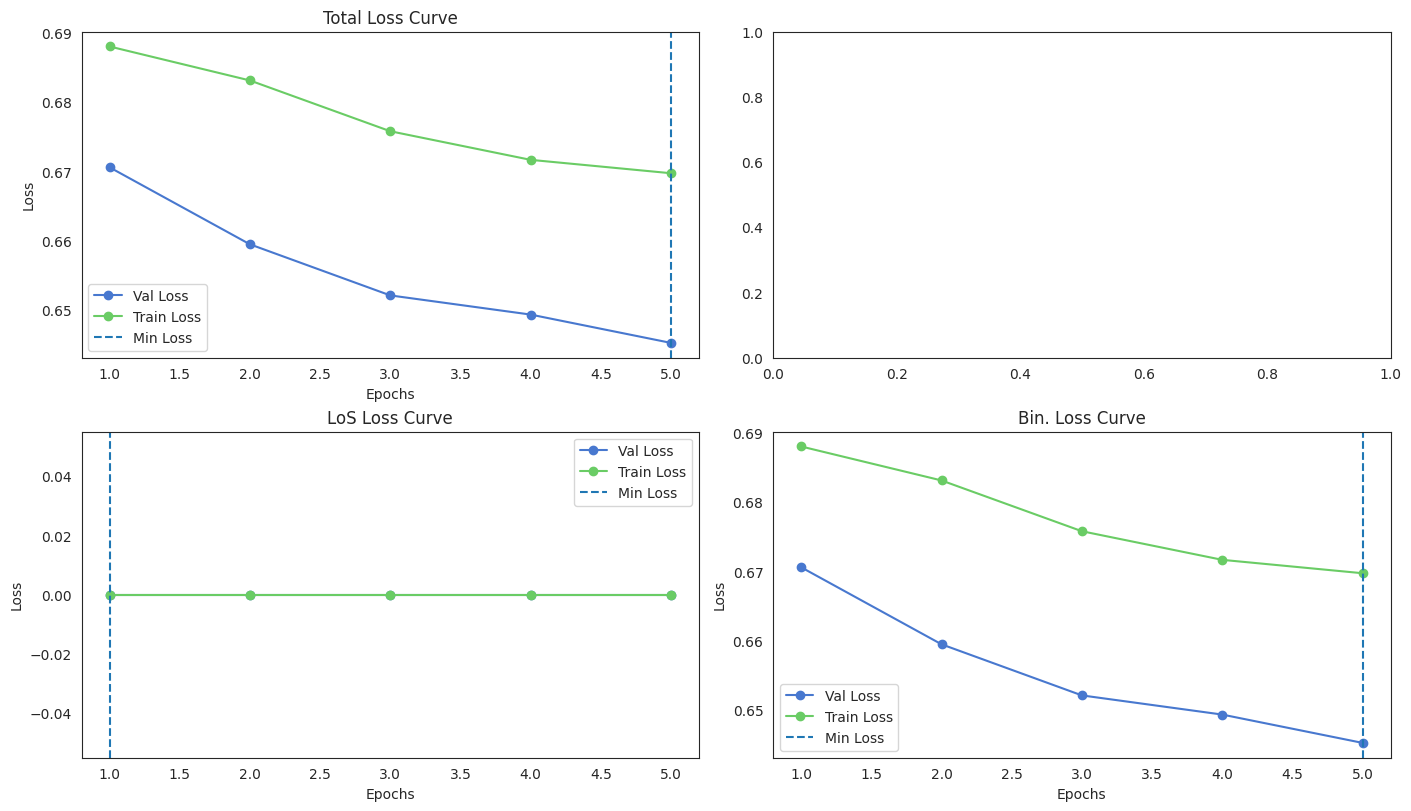

In [ ]:
import sys

sys.path.append("../")

import os
import time

# import dataset.loaders as loaders
# import utils.common as common
# from models.mimic_additive_sansformer import MimicAdditiveSansformerModel
# from models.mimic_axial_sansformer import MimicAxialSansformerModel
# from trainers.mimic_trainer import Trainer_MIMIC

MODEL_TYPE = {
    "add_SANSformer": MimicAdditiveSansformerModel,
    "axial_SANSformer": MimicAxialSansformerModel,
}


def run_experiment(cfg, train_dataloader, val_dataloader, test_dataloaders):

    assert (
        cfg.MODEL.TYPE in MODEL_TYPE.keys()
    ), f"Model type name should be among {MODEL_TYPE.keys()}"

    # define model
    model = MODEL_TYPE[cfg.MODEL.TYPE](cfg)
    # initialize the trainer
    trainer = Trainer_MIMIC(
        cfg, model, train_dataloader, val_dataloader, test_dataloaders
    )
    # fit on training data
    trainer.fit()
    # predict on valid and test data
    test_metrics_l = trainer.predict()

    log_test_results_to_csv(
        cfg,
        './drive/MyDrive/mimic-iv-1.0/results_log.csv',
        test_metrics_l,
    )


def main():
    starttime = time.time()
    # Parse cmd line args
    args = parse_args()
    cfg = handle_config_and_log_paths(args)
    # set experiment seed
    seed_everything(cfg.RNG_SEED)

    (
        train_dataloader,
        val_dataloader,
        test_dataloaders,
    ) = get_mimic_dataloaders(cfg)

    cfg.defrost()

    cfg.OPTIM.STEPS_PER_EPOCH = len(train_dataloader) // cfg.MODEL.ACCU_GRAD_STEPS
    print(f"Number of steps per epoch: {len(train_dataloader)}")

    cfg.MODEL.VOCAB_SIZE = train_dataloader.dataset.vectorizer.seq_vocab_len
    print(f"Total vocab size: {train_dataloader.dataset.vectorizer.seq_vocab_len}")

    cfg.freeze()

    print("=" * 100)
    print(f"Running Experiment: {cfg.PATHS.EXPERIMENT_NAME}")
    print("=" * 100)

    # run experiment
    run_experiment(cfg, train_dataloader, val_dataloader, test_dataloaders)

    print(f"Done in {(time.time() - starttime)/60} minutes.")


if __name__ == "__main__":
    sys.argv = ['script_name', '--cfg', './drive/MyDrive/mimic-iv-1.0/config_additive_sansformer_test.yml']
    main()

# Model comparison
  * As shown in the results displayed, specifically the auc_bin value, we can see that our model is being outperformed by all of the models that the authors are comparing sansformers to. However, there is room for improvement on our end.

  ![Model Comparison](https://drive.google.com/uc?export=view&id=1WyxfmGBbm5vT4QYtnD0vIigVzeFEUguv)



In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/mimic-iv-1.0/results_log.csv')

for index, row in df.iterrows():
    loss = row['loss']
    bin_loss = row['bin_loss']
    los_loss = row['los_loss']
    auc_bin = row['auc_bin']
    spearman_los = row['spearman_los']
    base_lr = row['base_lr']
    lr_policy = row['lr_policy']
    batch_size = row['batch_size']
    optim_momentum = row['optim_momentum']
    max_seq_length = row['max_seq_length']
    embed_size = row['embed_size']
    max_epochs = row['max_epochs']
    exp_dir = row['exp_dir']
    exp_name = row['exp_name']
    test_id = row['test_id']

    print(f"Loss: {loss}, bin_loss: {bin_loss}, los_loss: {los_loss}, auc_bin: {auc_bin}, spearman_los: {spearman_los}, base_lr: {base_lr}, lr_policy: {lr_policy}, batch_size: {batch_size}, optim_momentum: {optim_momentum}, max_seq_length: {max_seq_length}, embed_size: {embed_size}, max_epochs: {max_epochs}, exp_dir: {exp_dir}, exp_name: {exp_name}, test_id: {test_id}")


Loss: 0.674900051411681, bin_loss: 0.674900051411681, los_loss: 0.0, auc_bin: 0.646023880791255, spearman_los: nan, base_lr: 0.00059117, lr_policy: 1cycle, batch_size: 32, optim_momentum: 0.9, max_seq_length: 100, embed_size: 128, max_epochs: 5, exp_dir: ./experiments/default_addSANS/at_2024_04_14_21_18_55, exp_name: default_addSANS, test_id: 0


# Discussion

* **Reproducibility Assessment**: The paper is currently not reproducible since our results are not on par with those reported in the paper. In the Model Comparison section, our AUC result falls short compared to the other models evaluated by the authors. However, it's worth noting that we applied data sampling and modified configurations to reduce runtime, which might have affected our results.

* **Ease and Difficulty in Reproduction**: The easiest part of the reproduction process was leveraging the provided code from the paper's authors. However, a significant challenge arose due to missing code for the vectorizer. We had to collaborate with another group to obtain and save the missing vectorizer. This hurdle significantly delayed our progress in successfully running the training code on the model.

* **Suggestions for Improvement**: To enhance reproducibility, the authors could improve code readability by adding more comments and organizing it more efficiently. Additionally, providing the missing vectorizer code from the data preprocessing step would have been beneficial for reproducers. Clear documentation of dependencies and environment setup instructions would also facilitate easier reproduction.

* **Next Steps**: In the next phase, we aim to enhance the organization of our code and eliminate any Pummel-related processing and metrics. We also plan to perform training and evaluation on the other sansformers model, MIMIC Axial Sansformer. Furthermore, we plan to optimize the training process by training the model separately and loading it onto the notebook later. This strategy aims to reduce runtime, which is currently approximately 18 minutes for the entire notebook execution. Additionally, we intend to continue experimenting with different parameters to improve results while minimizing training and testing time.


# References

1. Y. Kumar, A. Ilin, H. Salo, S. Kulathinal, M. K. Leinonen and P. Marttinen, "Self-Supervised Forecasting in Electronic Health Records with Attention-Free Models," in IEEE Transactions on Artificial Intelligence, doi: 10.1109/TAI.2024.3353164.
keywords: {Medical services;Transformers;Data models;Predictive models;Computational modeling;Biological system modeling;Task analysis;Deep Learning;Electronic Health Records;Healthcare;Healthcare Utilization;Transfer Learning;Transformers},



